#### 📌 1️⃣ What is the Goal of the Model?

The goal is to **automate the selection of the best PSP (Payment Service Provider) for each transaction** so that we can:

1. **Maximize Payment Success Rate** → Choose the PSP most likely to lead to a successful payment.

2. **Minimize Transaction fees** → PSPs impose fees on both successful and failed transactions, so you want to reduce total cost per successful payment.

# 1. Import required libraries

In [6]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, RFECV, SelectKBest, f_classif

from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

from sklearn.inspection import permutation_importance

import joblib

# 2. Data Quality Assessment

**Data Quality Metrics:**
* `Data Type Validation`: Ensure timestamps are in datetime format. Ensure categorical variables are correctly labeled. Check for mixed data types in numerical column.
* `Completeness / Check for Missing Values`: Are all required fields populated? In other words, if there any missing value present in the dataset or not.
* `Uniqueness / Check for Duplicate records`: Are there duplicate records?
* `Accuracy`: Are values logically valid (e.g., positive amounts, valid PSP names)?
* `Consistency`: Do values remain consistent (e.g., same PSP names across records)?
* `Timeliness`: Are timestamps in the correct range and order?

**Data Preparation:**
* `Outlier Detection`: Examine "amount" for unusually large or small values using methods like IQR (Interquartile Range) or z-scores. If outliers present, handle them.
* `Feature Encoding`: Encode "country", "PSP", and "card" for machine learning models. Extract relevant components (e.g., hour, day, month) from "tmsp".
* `Scaling and Normalization`: Scale numerical feature "amount" to normalize distributions if necessary using StandardScaler (z-score normalization) or MinMaxScaler.
* `Data Aggregation`: Identify payment retries by grouping transactions with the same: "country", "amount", and "timestamps" within 1 minute. Create a new feature "attempt_count".



In [7]:
# define the file path
data_path = Path("../data/raw/PSP_Jan_Feb_2019.xlsx")

In [8]:
# load data
data = pd.read_excel(data_path)

# display the first few rows
data.head()

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [9]:
# shape of data
data.shape

(50410, 8)

In [10]:
# info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  50410 non-null  int64         
 1   tmsp        50410 non-null  datetime64[ns]
 2   country     50410 non-null  object        
 3   amount      50410 non-null  int64         
 4   success     50410 non-null  int64         
 5   PSP         50410 non-null  object        
 6   3D_secured  50410 non-null  int64         
 7   card        50410 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 3.1+ MB


#### Observation

* There are 50410 records & 8 columns in the data.
* There is no missing values present in any column.

**Column Overview:**
* `Unnamed: 0` : Appears to be an index column; we can drop it.
* `tmsp`: Timestamp of the transaction.
* `country`: Country where the transaction occurred.
* `amount`: Transaction amount.
* `success`: Binary (1 = success, 0 = failure)
* `PSP`: Payment Service Provider used.
* `3D_secured`: Binary (1 = secure payment, 0 = insecure).
* `card`: Credit card provider

In [11]:
# drop the unnecessary index column ("Unnamed: 0")
data_new = data.drop(columns=["Unnamed: 0"], axis=1)
data_new.head()

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [12]:
# check for null values
data_new.isnull().sum()

tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64

In [13]:
# check for duplicate data
data_new.duplicated().sum()

81

In [14]:
# check unique values in categorical features (e.g., country, PSP, card) -- for consistency check
print("Unique values in country feature: \n")
print(data_new["country"].unique())
print("\n----------------------")
print("\nUnique values in PSP feature: \n")
print(data_new["PSP"].unique())
print("\n----------------------")
print("\nUnique values in card feature: \n")
print(data_new["card"].unique())

Unique values in country feature: 

['Germany' 'Austria' 'Switzerland']

----------------------

Unique values in PSP feature: 

['UK_Card' 'Simplecard' 'Moneycard' 'Goldcard']

----------------------

Unique values in card feature: 

['Visa' 'Diners' 'Master']


In [15]:
# no. of records per category in each categorical variable
print("% of records present in each class of Country column:")
print((data_new["country"].value_counts() / len(data_new) * 100).round(2))
print("\n---------------------")

print("\nNo. of records of each class in PSP column: \n")
print((data_new["PSP"].value_counts() / len(data_new) * 100).round(2))
print("\n---------------------")

print("\nNo. of records of each class in 3D_secured column: \n")
print((data_new["3D_secured"].value_counts() / len(data_new) * 100).round(2))
print("\n---------------------")

print("\nNo. of records of each class in card column: \n")
print((data_new["card"].value_counts() / len(data_new) * 100).round(2))
print("\n---------------------")

print("\nNo. of records of each class in success column: \n")
print((data_new["success"].value_counts() / len(data_new) * 100).round(2))

% of records present in each class of Country column:
country
Germany        59.97
Switzerland    20.51
Austria        19.52
Name: count, dtype: float64

---------------------

No. of records of each class in PSP column: 

PSP
UK_Card       52.49
Simplecard    24.69
Moneycard     16.46
Goldcard       6.36
Name: count, dtype: float64

---------------------

No. of records of each class in 3D_secured column: 

3D_secured
0    76.17
1    23.83
Name: count, dtype: float64

---------------------

No. of records of each class in card column: 

card
Master    57.53
Visa      23.09
Diners    19.38
Name: count, dtype: float64

---------------------

No. of records of each class in success column: 

success
0    79.71
1    20.29
Name: count, dtype: float64


In [16]:
# get basic descriptive statistics
data_new[["amount", "success", "3D_secured"]].describe()

,amount,success,3D_secured
count,50410.000000,50410.000000,50410.000000
mean,202.395715,0.202896,0.238266
std,96.274730,0.402160,0.426027
min,6.000000,0.000000,0.000000
25%,133.000000,0.000000,0.000000
50%,201.000000,0.000000,0.000000
75%,269.000000,0.000000,0.000000
max,630.000000,1.000000,1.000000


In [17]:
# check for invalid / NaT (Not a Timestamp) or missing timestamps
invalid_timestamps = data_new[data_new["tmsp"].isna()]

if invalid_timestamps.empty:
  print("All timestamps are valid.")
else:
  print("Invalid timestamps detected:")
  print(invalid_timestamps)

All timestamps are valid.


In [18]:
# find the minimum and maximum timestamps (range check)
min_time = data_new["tmsp"].min()
max_time = data_new["tmsp"].max()

print(f"Timestamp Range: {min_time} to {max_time}")

Timestamp Range: 2019-01-01 00:01:11 to 2019-02-28 23:48:19


In [19]:
# check if timestamps are sorted in the correct order or not
if data_new["tmsp"].is_monotonic_increasing:
  print("Timestamps are in the correct order (increasing).")
else:
  print("Timestamps are NOT in the correct order.")

Timestamps are in the correct order (increasing).


In [20]:
# identify out-of-order timestamps
out_of_order_rows = data_new[data_new['tmsp'] < data_new['tmsp'].shift(1)]

if out_of_order_rows.empty:
  print("No out-of-order timestamps detected.")
else:
  print("Out-of-order timestamps found:")
  print(out_of_order_rows[["tmsp"]])

No out-of-order timestamps detected.


#### Observation
**Completeness / Check for Missing Values**: None found across the dataset.

**Uniqueness / Check for Duplicate records**: 81 duplicate rows detected. These can be removed to ensure data integrity.

**Accuracy**:
* All the categorical columns i.e., `country`, `success`, `PSP`, `3D_secured`, `card` has valid class names.
* The numerical column `amount` has valid values. The values range from €6 to 630, with a mean of €201.


**Consistency**:
The classes in each categorical variable are consistent. Same values are used in respective classes. No inconsistency observed.


**Timeliness**:
* The datetime column `tmsp` doesn't have any NaT value. The timestamp data are sorted in increasing order. There is no out-of-order timestamp record. The timestamp range is `2019-01-01 00:01:11 to 2019-02-28 23:48:19`.

**Descriptive Statistics**:
*   `amount`: Ranges from €6 to 630, with a mean of €201.
*   `success`: Approximately 20.3% of transactions are successful.
*   `3D_secured`: About 23.8% of transactions are 3D secured.

**Data Imbalance**:
* A dataset is considered imbalanced if the ratio between classes is greater than 4:1. In this case, the dataset has a 3.93:1 ratio, which is close to the threshold but still not highly imbalanced.
* Hence the dataset is **Mildly imbalanced**. While not extremely skewed, we may still consider handling imbalance with techniques like class weighting, SMOTE, or resampling.

# 3. Exploratory Data Analysis

In [21]:
# remove duplicates
data_cleaned = data_new.drop_duplicates()

# confirm the structure of the dataset after duplicate removal
print(data_cleaned.shape[0])

50329


In [22]:
data_cleaned.head()

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


#### Observation:

* Total rows: 50,329 (after removing 81 duplicates).
* Dataset structure is intact, with all relevant columns and no missing values. The dataset is now clean and ready for exploratory data analysis (EDA).

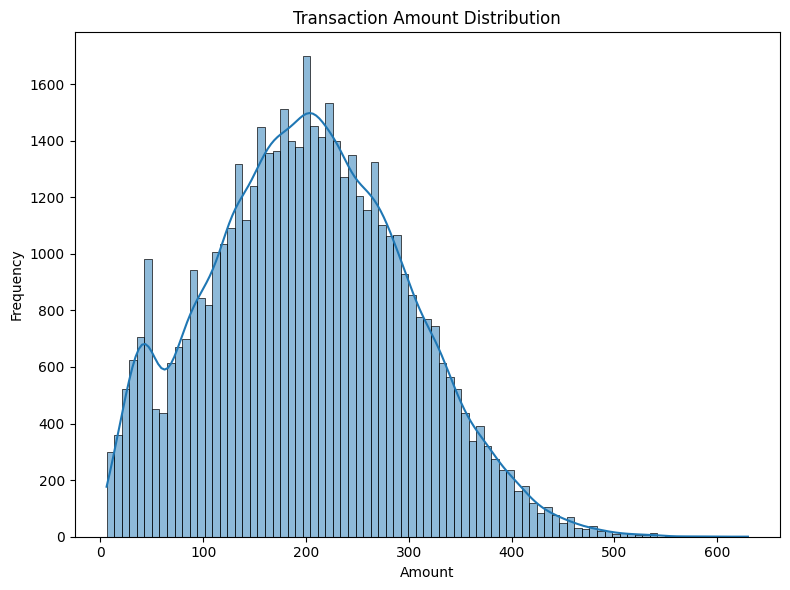

In [23]:
# identify outliers in the "amount" column

# visualize the distribution through histogram
plt.figure(figsize=(8, 6))
sns.histplot(data_cleaned["amount"], kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

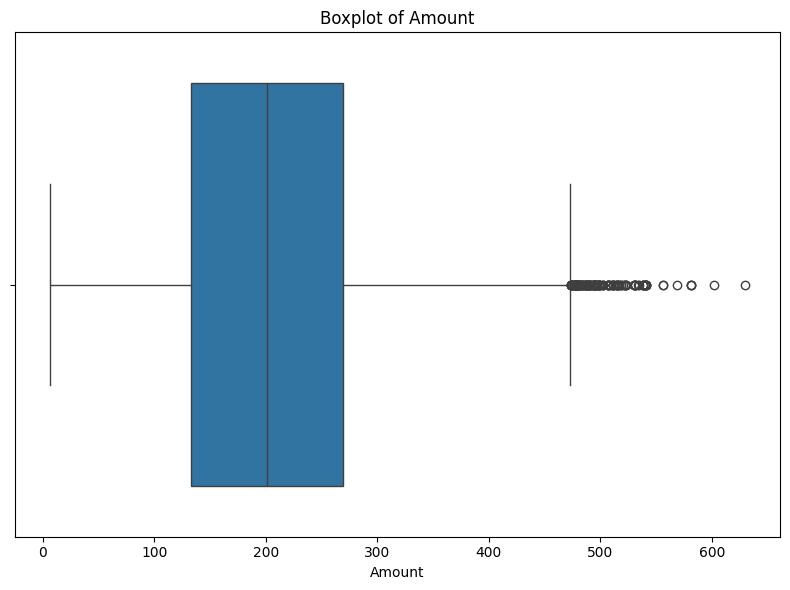

In [24]:
# visualize the distribution of data and highlight outliers as points outside the "whiskers"
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_cleaned["amount"])
plt.title("Boxplot of Amount")
plt.xlabel("Amount")
plt.tight_layout()
plt.show()

#### Observation

**From Histogram Visualization**:
* The histogram shows a **right-skewed** distribution, indicating that most transaction amounts are concentrated on the lower side, while fewer transactions occur with larger amounts.
* The highest frequency of transactions occurs at around 200 units of the transaction amount.
* Most transactions fall within the range of 0 to 300 units, with diminishing frequencies as the amounts increase beyond this range.
* Hence, the majority of transactions involve relatively small amounts. High-value transactions are infrequent but present, as evidenced by the long tail.

**From Boxplot Visualization**:
* The boxplot shows several data points outside the "upper whisker" which represent outliers. These are values that are significantly higher than the rest of the data.
* The box represents the middle 50% of the data (Q1 to Q3). The median (Q2) is slightly towards the lower half of the box, suggesting a right-skewed distribution.
* The left whisker is shorter than the right whisker, indicating that lower values are less spread out compared to higher values.
* This means most transaction amounts are concentrated at the lower end, but a few high-value transactions pull the distribution to the right.

In [25]:
# compute IQR
Q1 = data_cleaned["amount"].quantile(0.25)
Q3 = data_cleaned["amount"].quantile(0.75)
IQR = Q3 - Q1

# define outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# find outliers
outliers = data_cleaned[(data_cleaned["amount"] < lower_bound) | (data_cleaned["amount"] > upper_bound)]
outliers

,tmsp,country,amount,success,PSP,3D_secured,card
506,2019-01-01 09:48:03,Germany,488,0,UK_Card,0,Master
507,2019-01-01 09:48:48,Germany,488,0,UK_Card,0,Master
508,2019-01-01 09:49:35,Germany,488,0,Simplecard,0,Master
509,2019-01-01 09:49:41,Germany,488,0,UK_Card,0,Master
2135,2019-01-02 18:37:09,Switzerland,474,0,Simplecard,0,Master
2617,2019-01-03 04:06:18,Switzerland,499,0,UK_Card,0,Master
2618,2019-01-03 04:06:52,Switzerland,499,0,Simplecard,0,Master
2619,2019-01-03 04:07:34,Switzerland,499,0,UK_Card,0,Master
2620,2019-01-03 04:07:41,Switzerland,499,0,UK_Card,0,Master
2621,2019-01-03 04:08:22,Switzerland,499,0,UK_Card,0,Master


**Note**
* Outliers are not always bad—they can represent rare but important cases.
* If they affect model performance negatively, then we need to handle them.
* The correct approach is to train models with and without outliers and compare their performance, before deciding whether to remove or adjust them.
* If performance improves after removing outliers → Keep the cleaned data.
* If performance worsens or doesn’t change much → Keep the outliers.

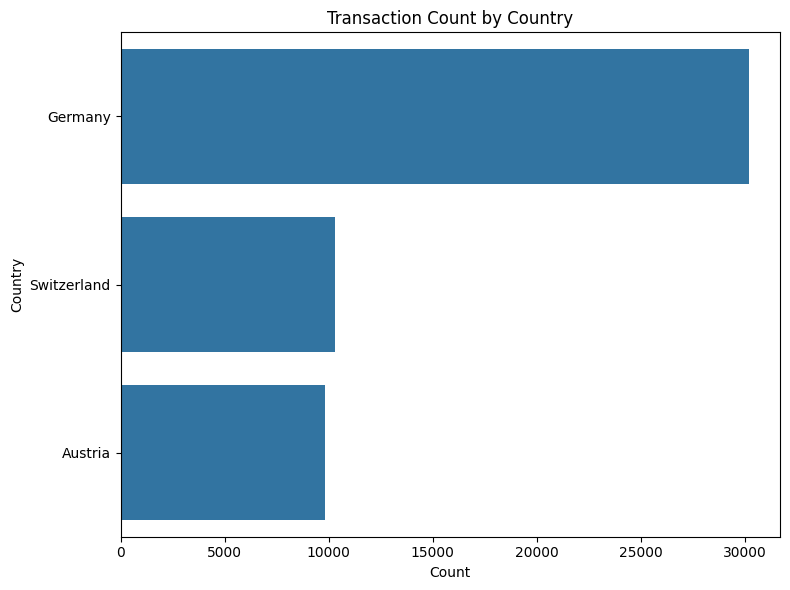

In [26]:
# analyzing transaction distribution by country
plt.figure(figsize=(8, 6))
sns.countplot(data=data_cleaned, y="country", order=data_cleaned["country"].value_counts().index)
plt.title("Transaction Count by Country")
plt.xlabel("Count")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

#### Observation

* **Germany** has the **highest number of transactions**, significantly more than the other countries.
* **Austria** has the **lowest transaction count** among the three countries.
* So, the majority of the transactions are happening in Germany, followed by Switzerland, while Austria has the least transactions.

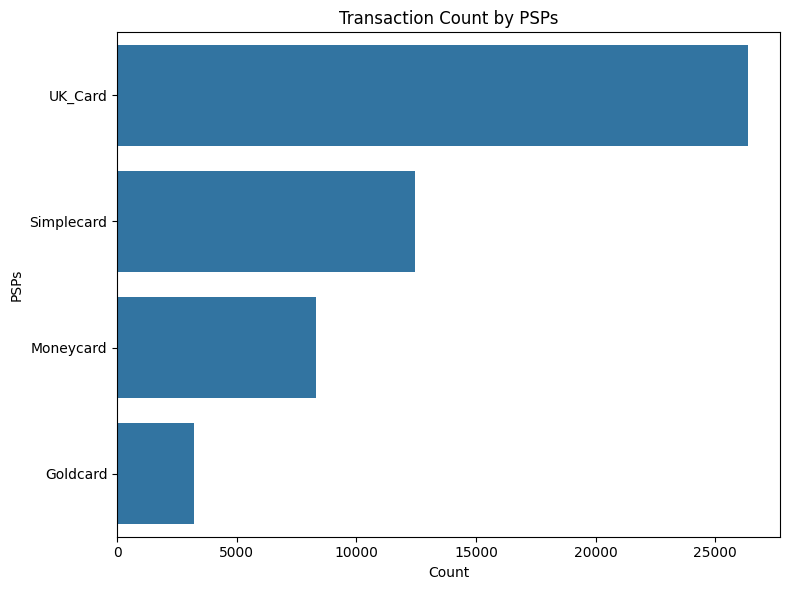

In [27]:
# analyzing transaction distribution by PSPs
plt.figure(figsize=(8, 6))
sns.countplot(data=data_cleaned, y="PSP", order=data_cleaned["PSP"].value_counts().index)
plt.title("Transaction Count by PSPs")
plt.xlabel("Count")
plt.ylabel("PSPs")
plt.tight_layout()
plt.show()

#### Observation

* **UK_Card** has the **highest number of transactions**, significantly more than the other PSPs.
* **Goldcard** has the **lowest transaction count** among the four PSPs.
* So, the majority of the transactions are happening through UK_Card, followed by Simplecard & Moneycard, while Goldcard has the least transactions.

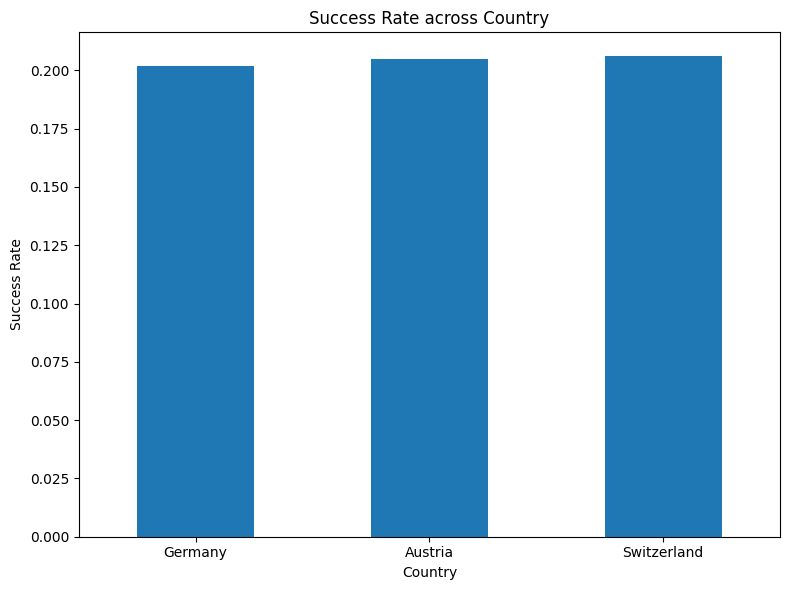

In [28]:
# analyzing success rate across countries

# success rate across PSPs
country_success_rate = data_cleaned.groupby("country")["success"].mean()

plt.figure(figsize=(8, 6))
country_success_rate.sort_values().plot(kind="bar")
plt.title("Success Rate across Country")
plt.xlabel("Country")
plt.ylabel("Success Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
country_success_rate

country
Austria        0.204969
Germany        0.201696
Switzerland    0.206025
Name: success, dtype: float64

#### Observation

* **Switzerland** has the **highest success rate** among all the countries.
* **Germany** has the **lowest success rate** among the countries.
* The success rate are more or less same across different countries, indicating that the choice of country doesn't has much impact on the success of transactions.

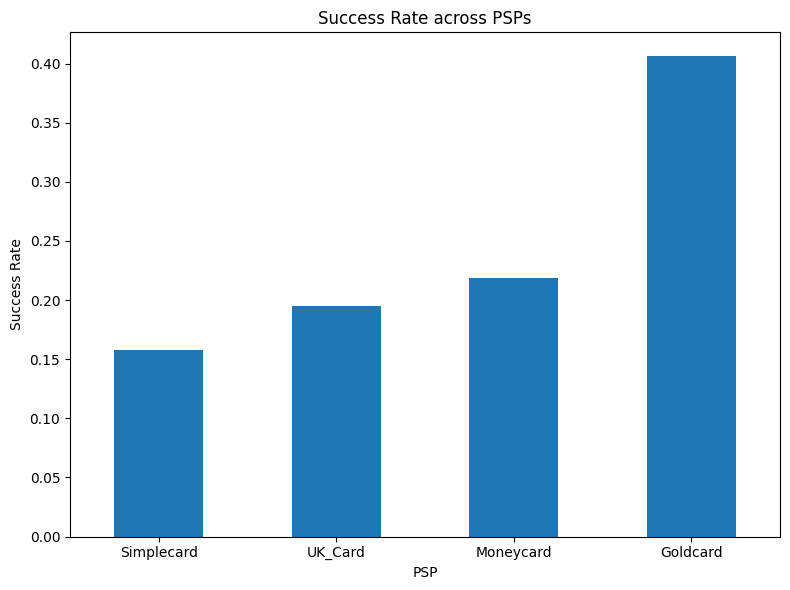

In [30]:
# analyzing success rate across PSPs

# success rate across PSPs
psp_success_rate = data_cleaned.groupby("PSP")["success"].mean()

plt.figure(figsize=(8, 6))
psp_success_rate.sort_values().plot(kind="bar")
plt.title("Success Rate across PSPs")
plt.xlabel("PSP")
plt.ylabel("Success Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Observation

* **Goldcard** has the **highest success rate** among all the PSPs.
* **Simplecard** has the **lowest success rate** among the PSPs.
* The success rate varies significantly across different PSPs, indicating that the choice of PSP has an impact on the success of transactions.
* In simple terms, for higher success in transactions, using **Goldcard** is more favorable compared to the others.

In [31]:
print("Number of transactions done per PSP:\n")
print(data_cleaned["PSP"].value_counts())
print("\n------------------------------------")
print("The proportion of successes and failures within each PSP:\n")
data_cleaned.groupby("PSP")["success"].value_counts(normalize=True)

Number of transactions done per PSP:

PSP
UK_Card       26388
Simplecard    12439
Moneycard      8294
Goldcard       3208
Name: count, dtype: int64

------------------------------------
The proportion of successes and failures within each PSP:



PSP         success
Goldcard    0          0.593828
            1          0.406172
Moneycard   0          0.781167
            1          0.218833
Simplecard  0          0.841788
            1          0.158212
UK_Card     0          0.805139
            1          0.194861
Name: proportion, dtype: float64

#### Observation

**Compare Success Rates & Transaction Volume**:

* `UK_Card` PSP has the highest transactions but low success rates (only 19.4%). It may signal high failure rates despite popularity.
* `Simplecard` PSP has the 2nd maximum number of transactions but the % of successful transactions is very less, even lesser than UK_Card (only 15.8%).
* `Moneycard` PSP has the 3rd maximum number of transactions but the % of successful transactions is also less (only 21.8%).
* `Goldcard` PSP has few transactions but a high success rate i.e., 40.6%. It could indicate it’s a premium service used by a niche audience.

<Figure size 1200x600 with 0 Axes>

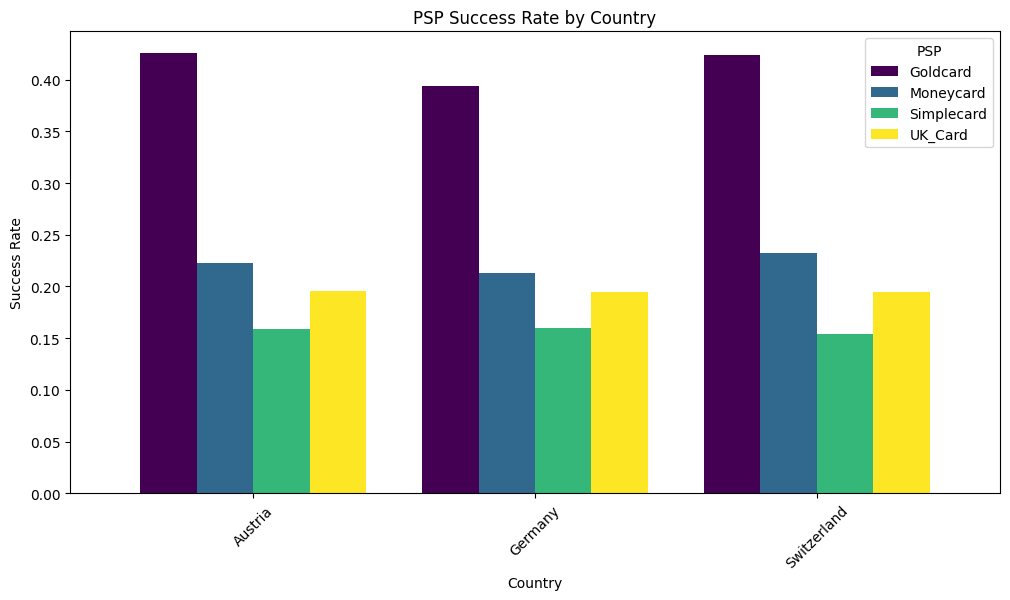

In [32]:
# analyzing PSP performance across countries
psp_country_success = data_cleaned.groupby(["PSP", "country"])["success"].mean().unstack()

plt.figure(figsize=(12, 6))
psp_country_success.T.plot(kind="bar", figsize=(12, 6), colormap="viridis", width=0.8)
plt.title("PSP Success Rate by Country")
plt.xlabel("Country")
plt.ylabel("Success Rate")
plt.xticks(rotation=45)
plt.legend(title="PSP")
plt.show()

In [33]:
psp_country_success

country,Austria,Germany,Switzerland
PSP,,,
Goldcard,0.425386,0.394018,0.424198
Moneycard,0.222626,0.212989,0.232323
Simplecard,0.158855,0.159397,0.154231
UK_Card,0.195980,0.194464,0.194958


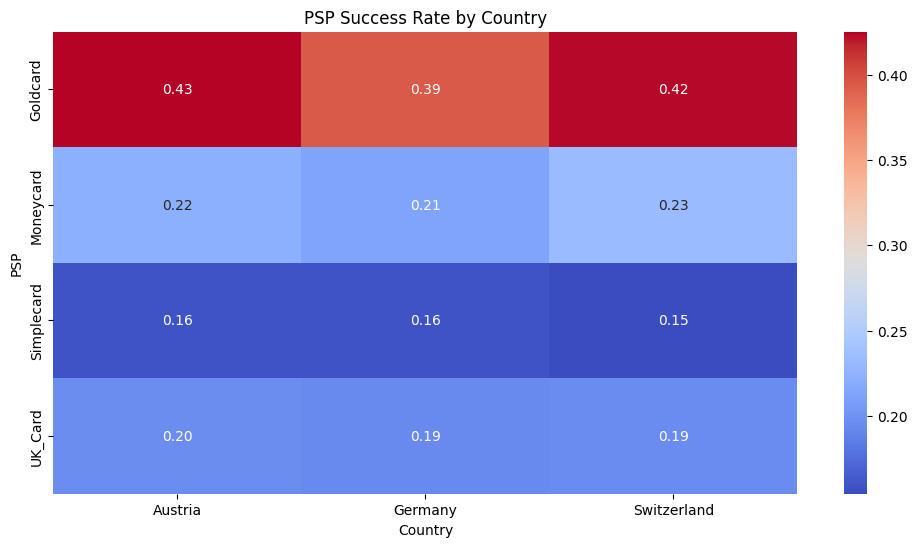

In [34]:
# Heatmap of success rates
plt.figure(figsize=(12, 6))
sns.heatmap(psp_country_success, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("PSP Success Rate by Country")
plt.xlabel("Country")
plt.ylabel("PSP")
plt.show()

#### Observation

* As we observed above, on the "country" level also **Goldcard has the highest success rate across all countries (~42%)**. Hence, Goldcard should be prioritized as a PSP option for transactions.
* **Simplecard has the lowest success rate across the countries (~15%)**. Hence, we can consider reducing reliance on it.
* **Moneycard performs slightly better in Switzerland (23%) than in Germany (21%) and Austria (22%)**.
* **UK_Card’s success rate is stable (~19.5%) across all countries**.


🤔 We also know that Germany accounts for almost 60% of all transactions. But its success rate is slightly lower than Austria & Switzerland. We need to investigate **which PSPs are used the most in Germany** and whether they contribute to the **lower success rate**. If Simplecard & UK_Card are widely used in Germany, that could explain the higher failure rate.

🤔 Switzerland has fewer transactions (~20%) but the highest success rate (~20.60%). We need to investigate **which PSPs are used the most in Germany** and whether they contribute to the **higher success rate**. If Goldcard is widely used in Germany, that could explain the higher success rate.

🤔 Austria’s Success Rate Is Slightly Lower Than Switzerland But Higher Than Germany. We need to compare PSP usage in Austria vs. Switzerland to see if PSP differences explain the success rate gap.

<Figure size 1200x600 with 0 Axes>

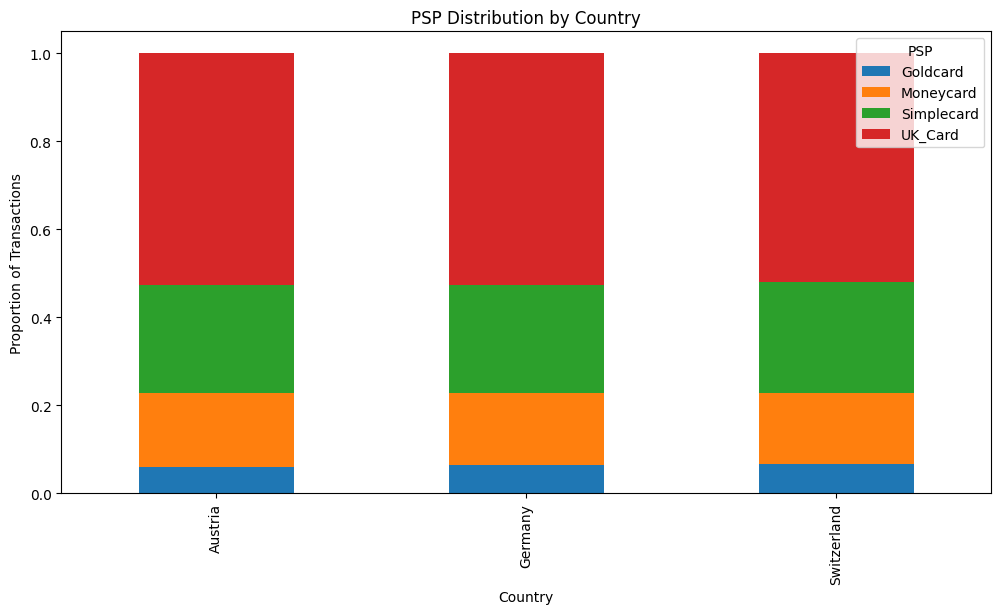

In [35]:
# compare PSP distribution across countries
psp_distribution = data_cleaned.groupby("country")["PSP"].value_counts(normalize=True).unstack()

plt.figure(figsize=(12, 6))
psp_distribution.plot(kind="bar", figsize=(12, 6), stacked=True)
plt.title("PSP Distribution by Country")
plt.xlabel("Country")
plt.ylabel("Proportion of Transactions")
plt.legend(title="PSP")
plt.show()

In [36]:
psp_distribution

PSP,Goldcard,Moneycard,Simplecard,UK_Card
country,,,,
Austria,0.059363,0.168313,0.245494,0.526830
Germany,0.064239,0.164259,0.246091,0.525411
Switzerland,0.066447,0.163018,0.251840,0.518694


#### Observation

* **UK_Card is the most used PSP across all three countries (~52%)**, followed by Simplecard (~25%), Moneycard (~16%), and Goldcard (~6%).
* **Goldcard (the best performing PSP) is used the least (~6%)**, while **Simplecard (the worst performing PSP) is the second most used (~25%)**.
* **Despite being used in over 50% of transactions, UK_Card’s success rate is below 20%**. **This is a major concern** because it indicates that a large portion of transactions rely on a **low-performing PSP**. Since **Germany has the most transactions (60% of total)** and **UK_Card is heavily used in Germany (~52%)**, this could explain why **Germany has the lowest success rate**.

💡 **Recommendation**: Shift more transactions away from UK_Card to a higher-performing PSP (e.g., Goldcard or Moneycard). Also investigate why UK_Card has a low success rate.

* **Goldcard consistently achieves a success rate of ~42% across all countries**, making it the most reliable PSP. However, **it is used in only ~6% of transactions**, which means **a huge opportunity is being missed**.

💡 **Recommendation**: Increase Goldcard’s usage by offering incentives or adjusting routing logic to prioritize Goldcard for transactions. Also investigate barriers preventing Goldcard from being used more frequently (e.g., availability in certain regions, higher fees).

* Simplecard is **used in nearly a quarter of all transactions** but **has the lowest success rate** across all countries. **This suggests that Simplecard is a major contributor to failed transactions**.

💡 **Recommendation**: Reduce the reliance on Simplecard. Also Check failure reasons for Simplecard transactions.

* **Switzerland has the highest success rate because it uses UK_Card slightly less**. The difference in PSP distribution is small, but **Switzerland has slightly fewer transactions via UK_Card (51.87%) compared to Germany & Austria**. Instead, Switzerland has **slightly more transactions via Goldcard (~6.64%)**, which perform better.

💡 **Recommendation**: Apply Switzerland’s PSP distribution strategy in other countries, especially Germany, where success rates are lower.

In [37]:
# bin the amount
bin_labels_ = ["Low", "Medium", "High", "Very High"]
bin_edges_ = data_cleaned['amount'].quantile([0, 0.25, 0.5, 0.75, 1.0]).values

<Figure size 1200x600 with 0 Axes>

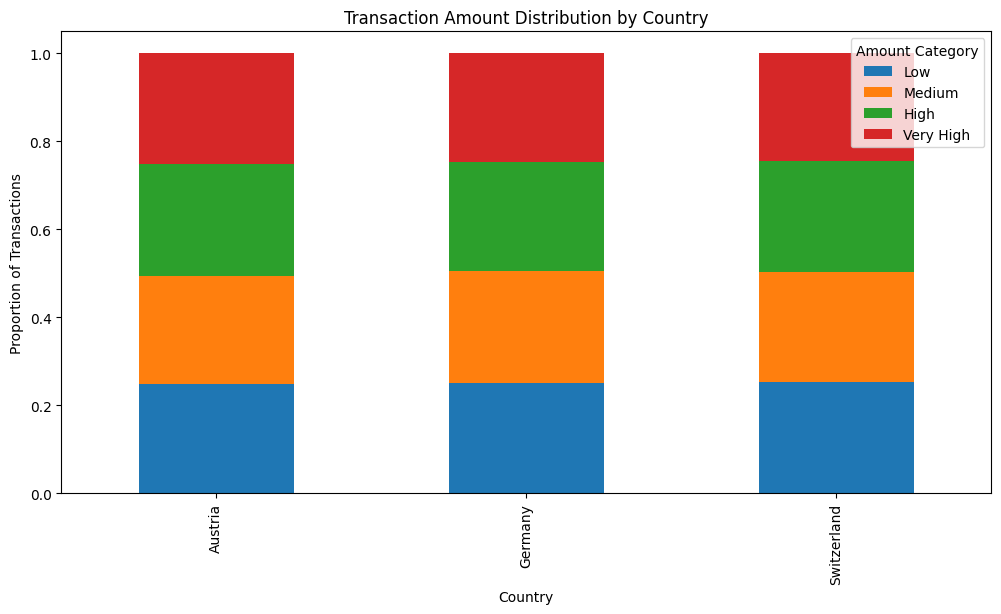

In [39]:
# compare transaction amounts across countries
data_cleaned["amount_category"] = pd.qcut(data_cleaned["amount"], q=4, labels=bin_labels_)

amount_distribution = data_cleaned.groupby("country")["amount_category"].value_counts(normalize=True).unstack()

plt.figure(figsize=(12, 6))
amount_distribution.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Transaction Amount Distribution by Country")
plt.xlabel("Country")
plt.ylabel("Proportion of Transactions")
plt.legend(title="Amount Category")
plt.show()

In [40]:
amount_distribution

amount_category,Low,Medium,High,Very High
country,,,,
Austria,0.248651,0.246614,0.253538,0.251196
Germany,0.250696,0.254174,0.247813,0.247316
Switzerland,0.253778,0.250194,0.252615,0.243413


#### Observation

* **Switzerland has the lowest percentage of Very High transactions (24.34%)**, meaning **fewer large-value transactions are being processed**.
* **Germany has slightly fewer High-Value transactions than Austria (~24.78% vs. 25.35%)**, but not by a large margin.
* **Switzerland has the highest success rate because it handles fewer High-Value transactions**. Switzerland has the lowest proportion of "Very High" transactions (~24.34%), which suggests that **lower-value transactions are more likely to succeed**. Since high-value transactions have a higher chance of being flagged for fraud, Switzerland might have fewer fraudulent or risky transactions, leading to higher success rates. **Germany has more Very High-value transactions (~24.73%)**, which might explain its slightly lower success rate (~20.17%).

📌 **PSP Choice has a bigger impact on success rate than transaction amount**.
* Goldcard (42%) outperforms UK_Card (19%) & Simplecard (15%) across all countries.
* **Despite handling a similar mix of transaction amounts, Switzerland succeeds more often** → likely because it **uses slightly more Goldcard (~6.64%) and slightly less UK_Card (~51.87%) than Germany & Austria**.
* **Germany & Austria heavily rely on UK_Card (~52%) & Simplecard (~25%), lowering their overall success rates**.

💡 **Recommendation**: Encourage a shift from UK_Card & Simplecard to Goldcard & Moneycard, especially in Germany (where success rates are lowest).

🤔 High-Value Transactions may be more prone to Failures in certain PSPs. Since Switzerland has fewer Very High transactions (~24.34%) and the highest success rate (20.60%), it's possible that higher-value transactions fail more frequently in Germany & Austria. **We should analyze whether UK_Card & Simplecard struggle with high-value transactions**.

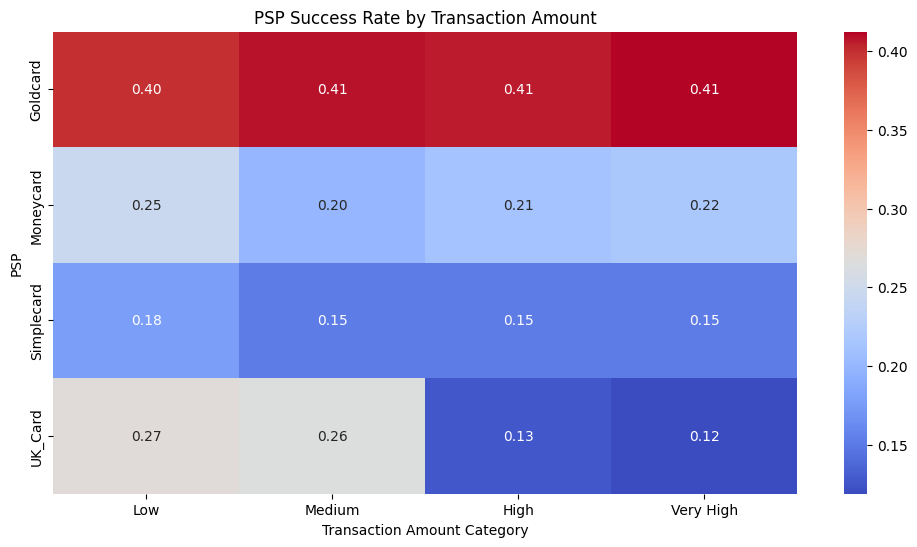

In [41]:
# analyse success rates for different PSPs by transaction amount category
psp_amount_success = data_cleaned.groupby(["PSP", "amount_category"])["success"].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(psp_amount_success, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("PSP Success Rate by Transaction Amount")
plt.xlabel("Transaction Amount Category")
plt.ylabel("PSP")
plt.show()

In [42]:
psp_amount_success

amount_category,Low,Medium,High,Very High
PSP,,,,
Goldcard,0.398734,0.407862,0.405797,0.412371
Moneycard,0.245202,0.199906,0.212329,0.218093
Simplecard,0.178082,0.151372,0.151786,0.151353
UK_Card,0.270103,0.264496,0.126180,0.118836


#### Observation

📌 **Goldcard Performs consistently well across all transaction amounts**.
* Goldcard has the highest success rate (~40%) in all categories, including Very High transactions.
* In fact, its success rate slightly increases for Very High transactions (41.24%).
* **This suggests that Goldcard is the most stable PSP across all transaction amounts**.

💡 **Recommendation**: Prioritize routing high-value transactions through Goldcard, especially since it handles them well.

📌 **UK_Card's success rate drops drastically for High-Value transactions**.
* UK_Card handles Low & Medium transactions decently (~27% success rate).
* However, its success rate for High & Very High transactions is extremely low (~12%).
* **This indicates that UK_Card is not reliable for larger transactions**.

💡 **Recommendation**: Do NOT use UK_Card for high-value transactions. If a transaction is High or Very High, route it through Goldcard or Moneycard instead.

📌 **Simplecard has the lowest success rate & performs poorly at all amount levels**.
* Simplecard's success rate is consistently low (~15%) across all transaction categories.
* **Unlike UK_Card, it doesn’t have a drastic drop-off, but it also doesn’t handle any transaction amounts well**.

💡 **Recommendation**: Minimize reliance on Simplecard entirely. If it's used due to lower fees, **reevaluate whether the cost savings outweigh the revenue lost from failed transactions**.

📌 **Moneycard struggles with Medium transactions but recovers slightly for High & Very High transactions**.
* Moneycard’s success rate is 24.52% for Low, but it drops to 19.99% for Medium transactions.
* However, it slightly recovers for High & Very High transactions (~21%).
* This suggests **Moneycard might handle larger transactions slightly better than UK_Card but is still unreliable compared to Goldcard**.

💡 **Recommendation**: Use Moneycard for High & Very High transactions only if Goldcard is unavailable. Investigate why Medium transactions fail more for Moneycard compared to Low/High transactions.

🤔 Since Germany already had the lowest success rate, does UK_Card perform even worse for Very High transactions in Germany?

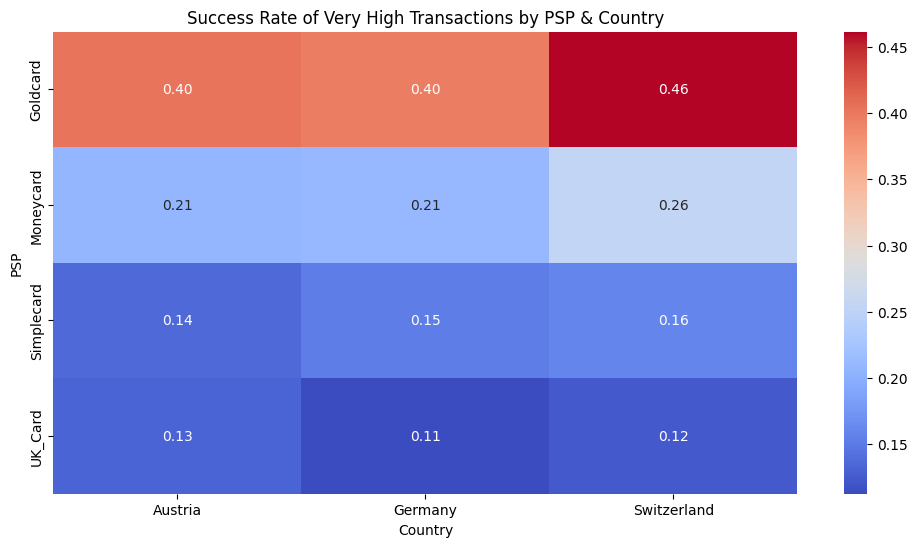

In [43]:
# compare PSP performance across countries for Very High transactions
high_value_psp_country = data_cleaned[data_cleaned["amount_category"] == "Very High"].groupby(["PSP", "country"])["success"].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(high_value_psp_country, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Success Rate of Very High Transactions by PSP & Country")
plt.xlabel("Country")
plt.ylabel("PSP")
plt.show()

In [44]:
high_value_psp_country

country,Austria,Germany,Switzerland
PSP,,,
Goldcard,0.403974,0.396930,0.461538
Moneycard,0.206651,0.209664,0.255583
Simplecard,0.136752,0.153371,0.159236
UK_Card,0.132824,0.112525,0.124143


#### Observation

📌 **PSP Selection significantly impacts High-Value transaction success rates**
* **Goldcard remains the best PSP for Very High transactions, with its highest success rate in Switzerland (46.15%)**.
* **UK_Card has the worst success rate for Very High transactions across all countries, especially in Germany (~11.25%)**.
* **Moneycard and Simplecard struggle across all countries but perform slightly better in Switzerland**.

💡 **Recommendation**: Redirect high-value transactions away from UK_Card and towards Goldcard. If Goldcard is unavailable, Moneycard is the second-best option (but still weaker than Goldcard).

📌 **Germany’s High-Value Transactions Have the Worst Success Rates**
* Germany has the lowest success rate for high-value transactions across all PSPs.
* **UK_Card fails the most in Germany (11.25%), meaning high-value transactions in Germany are highly likely to fail**.
* Even Goldcard underperforms in Germany compared to Switzerland (~39.69% vs. 46.15%).

💡 **Recommendation**: Investigate if German banks have stricter approval policies for high-value transactions. Optimize PSP selection specifically for Germany to reduce failures.

📌 **Switzerland handles Very High transactions best**
* Switzerland has the highest success rates across all PSPs, especially for Goldcard (46.15%).
* **This suggests that Switzerland has fewer restrictions or more PSP-friendly regulations**.

💡 **Recommendation**: If possible, process Very High transactions through Swiss banks or PSPs operating in Switzerland.

🤔 Since we suspect that **high-value transactions fail significantly more than low-value ones, especially for UK_Card**, we can run a **statistical hypothesis test** to confirm whether this difference is statistically significant.

**Null Hypothesis (H0)**:
*The success rate of transactions does not depend on the transaction amount.*

**Alternative Hypothesis (H1)**:
*The success rate of transactions decreases significantly as transaction amount increases.*

**We can use a Chi-Square test to check if there is a statistically significant relationship between transaction amount and success rate**.

In [45]:
# create a contingency table
contingency_table = pd.crosstab(data_cleaned["amount_category"], data_cleaned["success"])

# perform chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")

# check if P-Value < 0.05 (5% significance level)
if p < 0.05:
  print("There is a statistically significant relationship between transaction amount and success rate.")
else:
  print("There is NO statistically significant relationship between transaction amount and success rate.")

Chi-Square Statistic: 505.2931736610211
P-Value: 3.400558089068172e-109
There is a statistically significant relationship between transaction amount and success rate.


#### Observation

* **The P-value is nearly 0**, meaning **transaction amount significantly impacts success rates**.
* This confirms that **Very High transactions fail more frequently than Low & Medium transactions**.

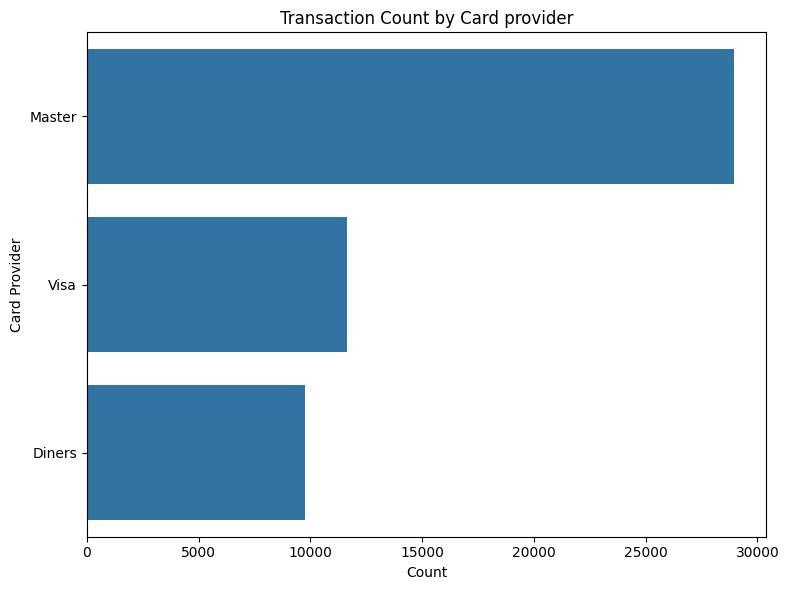

In [46]:
# analyzing transaction distribution by card provider
plt.figure(figsize=(8, 6))
sns.countplot(data=data_cleaned, y="card", order=data_cleaned["card"].value_counts().index)
plt.title("Transaction Count by Card provider")
plt.xlabel("Count")
plt.ylabel("Card Provider")
plt.tight_layout()
plt.show()

In [47]:
print("% of transactions done per card provider:\n")
print((data_cleaned["card"].value_counts() / len(data_cleaned) * 100).round(2))

% of transactions done per card provider:

card
Master    57.52
Visa      23.10
Diners    19.38
Name: count, dtype: float64


#### Observation

* **MasterCard has the highest number of transactions (~58%)**, followed by **Visa (~23%)** and **Diners (~19%)**. **Diners has the least transactions**.
* Hence, **MasterCard is the most commonly used card provider across all countries**. **Diners is a niche provider, used far less frequently**.

💡 **Recommendation**: Investigate why MasterCard dominates the transactions—are users naturally preferring it, or is it due to PSP preferences?

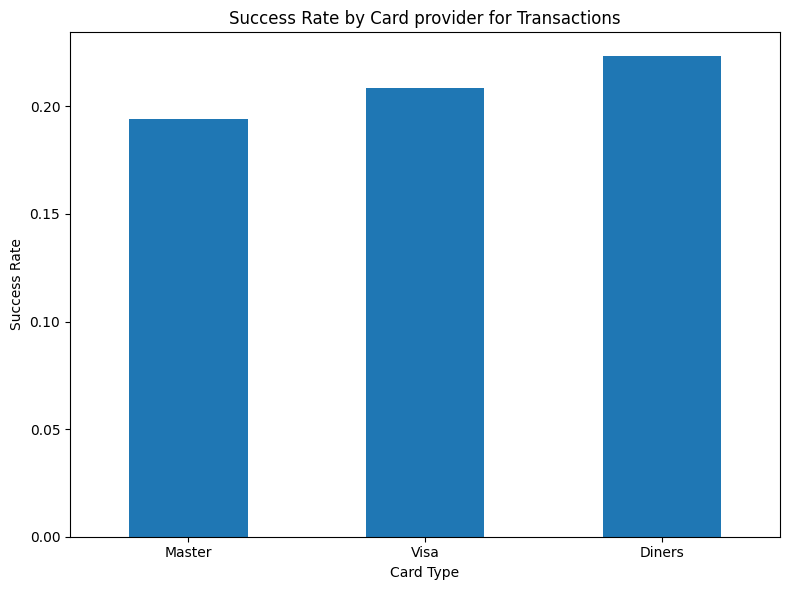

In [48]:
# analyzing success rate by card providers for transaction

# success rate across card providers
card_success_rate = data_cleaned.groupby("card")["success"].mean()

plt.figure(figsize=(8, 6))
card_success_rate.sort_values().plot(kind="bar")
plt.title("Success Rate by Card provider for Transactions")
plt.xlabel("Card Type")
plt.ylabel("Success Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [49]:
card_success_rate

card
Diners    0.223247
Master    0.194252
Visa      0.208756
Name: success, dtype: float64

#### Observation

* **Diners has the highest success rate (~22.3%), even though it has the lowest transaction count**.
* **MasterCard has the lowest success rate (~19.4%) despite handling most transactions**.

💡 **Recommendation**:
* Investigate why MasterCard struggles with success rate—is it due to PSP choices?
* Increase Diners usage if success rate is a priority (if fees aren’t a constraint).

In [50]:
print("Number of transactions done per card provider:\n")
print(data_cleaned["card"].value_counts())
print("\n------------------------------------")
print("The proportion of successes and failures within each card provider:\n")
data_cleaned.groupby("card")["success"].value_counts(normalize=True)

Number of transactions done per card provider:

card
Master    28947
Visa      11626
Diners     9756
Name: count, dtype: int64

------------------------------------
The proportion of successes and failures within each card provider:



card    success
Diners  0          0.776753
        1          0.223247
Master  0          0.805748
        1          0.194252
Visa    0          0.791244
        1          0.208756
Name: proportion, dtype: float64

#### Observation

* **All card providers have high failure rates (~77-81%).**
* **Diners has the lowest failure rate (~77.7%), while MasterCard has the highest (~80.6%)**.

💡 **Recommendation**:
* Check why MasterCard fails more—is it due to PSP routing issues?
* Diners is underutilized but performs well, evaluate whether shifting some transactions to Diners improves overall success rate.

<Figure size 1200x600 with 0 Axes>

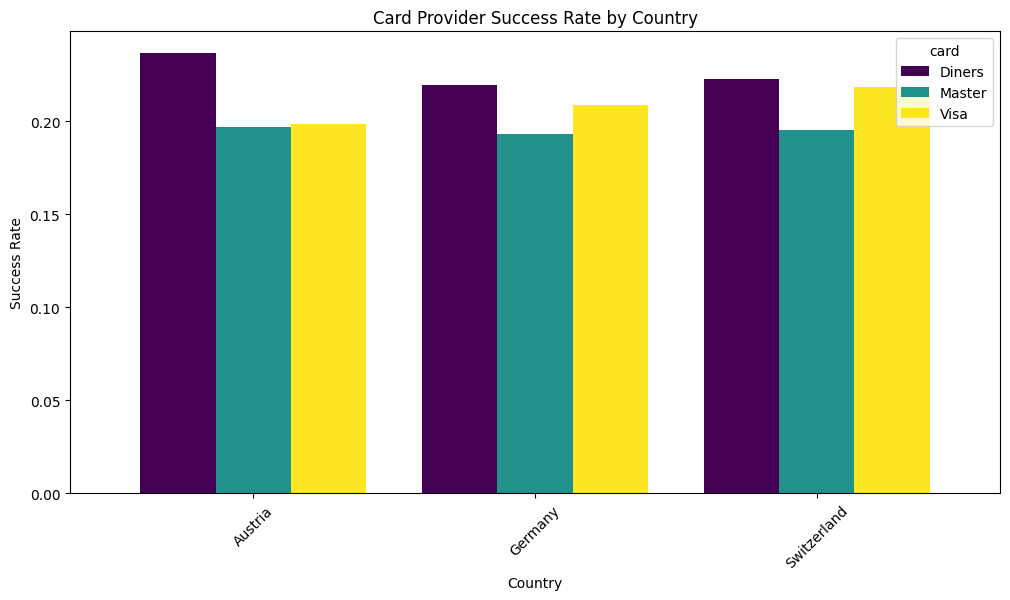

In [51]:
# analyzing card provider performance across countries
card_country_success = data_cleaned.groupby(["card", "country"])["success"].mean().unstack()

plt.figure(figsize=(12, 6))
card_country_success.T.plot(kind="bar", figsize=(12, 6), colormap="viridis", width=0.8)
plt.title("Card Provider Success Rate by Country")
plt.xlabel("Country")
plt.ylabel("Success Rate")
plt.xticks(rotation=45)
plt.legend(title="card")
plt.show()

In [52]:
card_country_success

country,Austria,Germany,Switzerland
card,,,
Diners,0.236364,0.219104,0.222541
Master,0.196799,0.193137,0.195089
Visa,0.198643,0.208652,0.218512


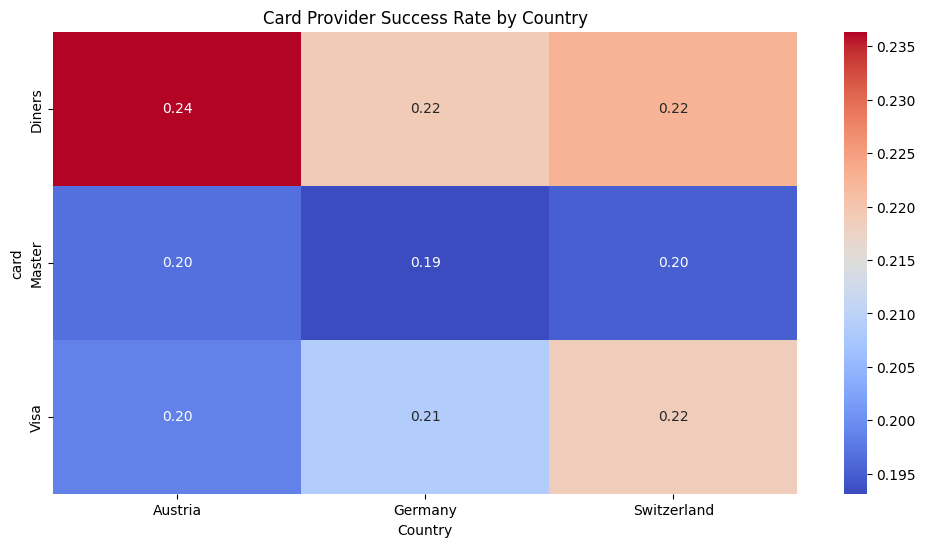

In [53]:
# Heatmap of card provider performance across countries
plt.figure(figsize=(12, 6))
sns.heatmap(card_country_success, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Card Provider Success Rate by Country")
plt.xlabel("Country")
plt.ylabel("card")
plt.show()

#### Observation

* **Diners performs best in Austria (~23.64%)** but also does well in other countries.
* **MasterCard has a consistently low success rate (~19-20%) across all countries**.
* **Visa performs slightly better in Switzerland (~21.85%)**.

<Figure size 1200x600 with 0 Axes>

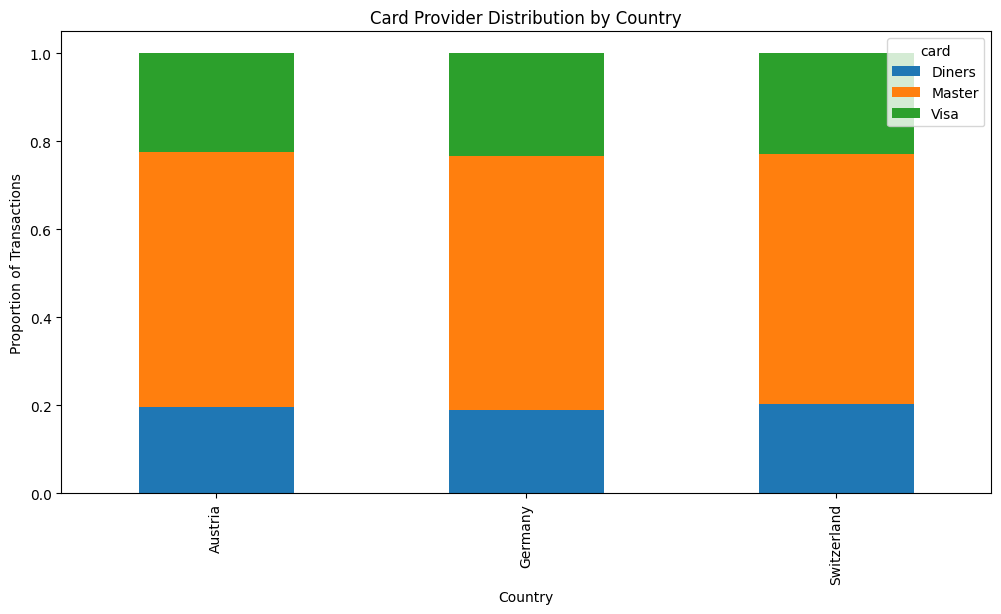

In [54]:
# compare card provider distribution across countries
card_distribution = data_cleaned.groupby("country")["card"].value_counts(normalize=True).unstack()

plt.figure(figsize=(12, 6))
card_distribution.plot(kind="bar", figsize=(12, 6), stacked=True)
plt.title("Card Provider Distribution by Country")
plt.xlabel("Country")
plt.ylabel("Proportion of Transactions")
plt.legend(title="card")
plt.show()

In [55]:
card_distribution

card,Diners,Master,Visa
country,,,
Austria,0.196009,0.578963,0.225028
Germany,0.190068,0.576365,0.233567
Switzerland,0.202828,0.567997,0.229175


#### Observation

* **MasterCard is dominant across all countries (~57%)**.
* **Visa has slightly higher usage in Germany (~23.3%)**.
* **Diners is used slightly more in Switzerland (~20.3%)**.

💡 **Recommendation**:
* Optimize PSP selection for each card provider based on success rates.

<Figure size 1200x600 with 0 Axes>

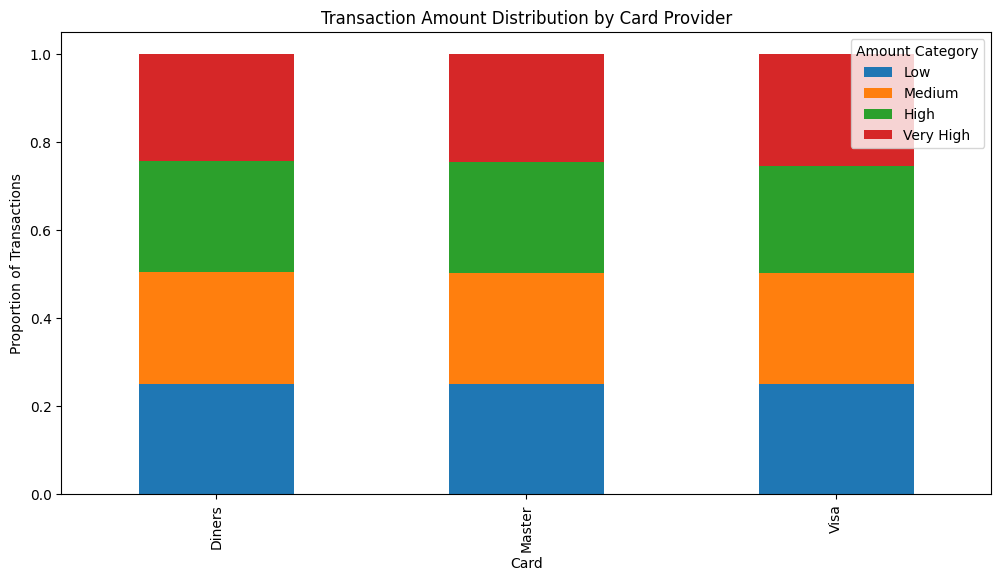

In [56]:
# compare transaction amounts across card providers
amount_card_distribution = data_cleaned.groupby("card")["amount_category"].value_counts(normalize=True).unstack()

plt.figure(figsize=(12, 6))
amount_card_distribution.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Transaction Amount Distribution by Card Provider")
plt.xlabel("Card")
plt.ylabel("Proportion of Transactions")
plt.legend(title="Amount Category")
plt.show()

In [57]:
amount_card_distribution

amount_category,Low,Medium,High,Very High
card,,,,
Diners,0.249692,0.254715,0.252768,0.242825
Master,0.251460,0.250907,0.251632,0.246001
Visa,0.250645,0.251935,0.243248,0.254172


#### Observation

* **Visa handles more Very High transactions (~25.41%)**.
* **Diners handles the fewest Very High transactions (~24.28%)**.

💡 **Recommendation**: Visa is handling more Very High transactions, but Diners has the highest success rate, we should compare their performance for Very High transactions.

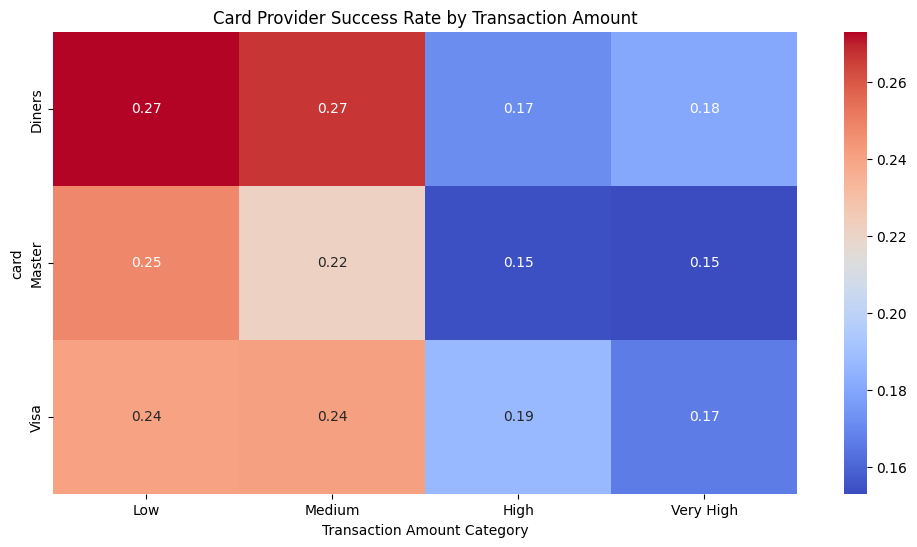

In [58]:
# analyse success rates for different card providers by transaction amount category
card_amount_success = data_cleaned.groupby(["card", "amount_category"])["success"].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(card_amount_success, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Card Provider Success Rate by Transaction Amount")
plt.xlabel("Transaction Amount Category")
plt.ylabel("card")
plt.show()

In [59]:
card_amount_success

amount_category,Low,Medium,High,Very High
card,,,,
Diners,0.272989,0.266801,0.171533,0.180245
Master,0.248111,0.220983,0.154174,0.152928
Visa,0.240563,0.241038,0.187058,0.166159


#### Observation

* **Diners has the highest success rate for most of the transaction amounts**.
* **Visa performs better for High transactions (~18.71%)**.
* **MasterCard has the lowest success rate across all transaction amounts**.

💡 **Recommendation**:
* **Avoid using MasterCard for Very High transactions**.
* **Prefer Diners for all transactions where possible**.

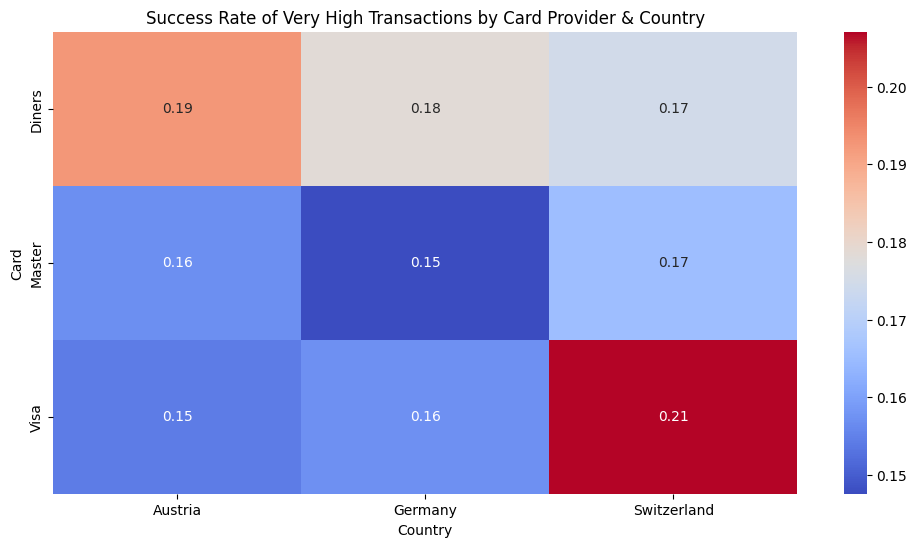

In [60]:
# compare Card Provider performance across countries for Very High transactions
high_value_card_country = data_cleaned[data_cleaned["amount_category"] == "Very High"].groupby(["card", "country"])["success"].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(high_value_card_country, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Success Rate of Very High Transactions by Card Provider & Country")
plt.xlabel("Country")
plt.ylabel("Card")
plt.show()

In [61]:
high_value_card_country

country,Austria,Germany,Switzerland
card,,,
Diners,0.192560,0.178414,0.174545
Master,0.157013,0.147552,0.165236
Visa,0.154246,0.157198,0.207080


#### Observation

* **Visa performs best in Switzerland for Very High transactions (~20.71%)**.
* **MasterCard performs the worst across all countries (~14-16%)**.
* **Diners still performs the best overall**.

💡 **Recommendation**:
* **Use Visa for Very High transactions in Switzerland**.
* **Avoid MasterCard for Very High transactions in all countries**.

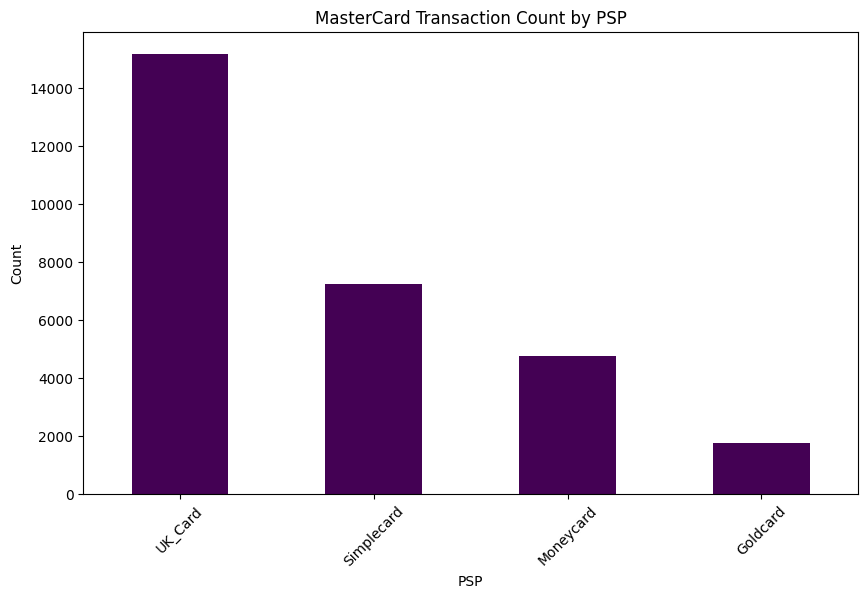

In [62]:
# analyzing why MasterCard struggles with success rate

# find out if MasterCard transactions are disproportionately using low-performing PSPs (like UK_Card or Simplecard)
mc_psp_distribution = data_cleaned[data_cleaned["card"] == "Master"].groupby("PSP")["success"].count().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mc_psp_distribution.plot(kind="bar", colormap="viridis")
plt.title("MasterCard Transaction Count by PSP")
plt.xlabel("PSP")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [63]:
mc_psp_distribution

PSP
UK_Card       15179
Simplecard     7241
Moneycard      4764
Goldcard       1763
Name: success, dtype: int64

#### Observation

* UK_Card and Simplecard handle the majority (~75%) of MasterCard transactions.
* Goldcard, the best-performing PSP, is underutilized for MasterCard.
* Since **most MasterCard transactions are handled by UK_Card or Simplecard, PSP choice is a major factor in its poor performance**.

💡 **Recommendation**: Shift MasterCard transactions away from UK_Card & Simplecard and towards Goldcard & Moneycard.

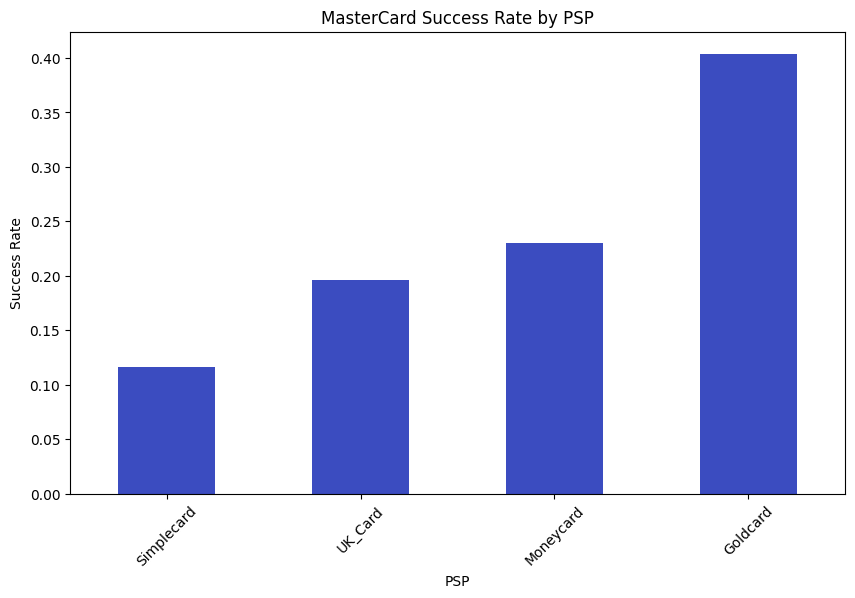

In [64]:
# success rate of MasterCard for each PSP
# find out which PSPs handle Mastercard well and which ones fail the most
mc_psp_success = data_cleaned[data_cleaned["card"] == "Master"].groupby("PSP")["success"].mean().sort_values()

plt.figure(figsize=(10, 6))
mc_psp_success.plot(kind="bar", colormap="coolwarm")
plt.title("MasterCard Success Rate by PSP")
plt.xlabel("PSP")
plt.ylabel("Success Rate")
plt.xticks(rotation=45)
plt.show()

In [65]:
mc_psp_success

PSP
Simplecard    0.116697
UK_Card       0.195731
Moneycard     0.229849
Goldcard      0.403857
Name: success, dtype: float64

#### Observation

* Simplecard is the worst PSP for MasterCard (~11.67% success rate).
* Goldcard has the highest MasterCard success rate (~40.39%) but is barely used.
* UK_Card (most used) has a low success rate (~19.57%).
* **Mastercard transactions fail more with UK_Card & Simplecard** but succeed with Goldcard. Hence **PSP selection is the issue**.

💡 **Recommendation**:
* Reduce MasterCard transactions routed through Simplecard & UK_Card.
* Prioritize routing MasterCard transactions through Goldcard.

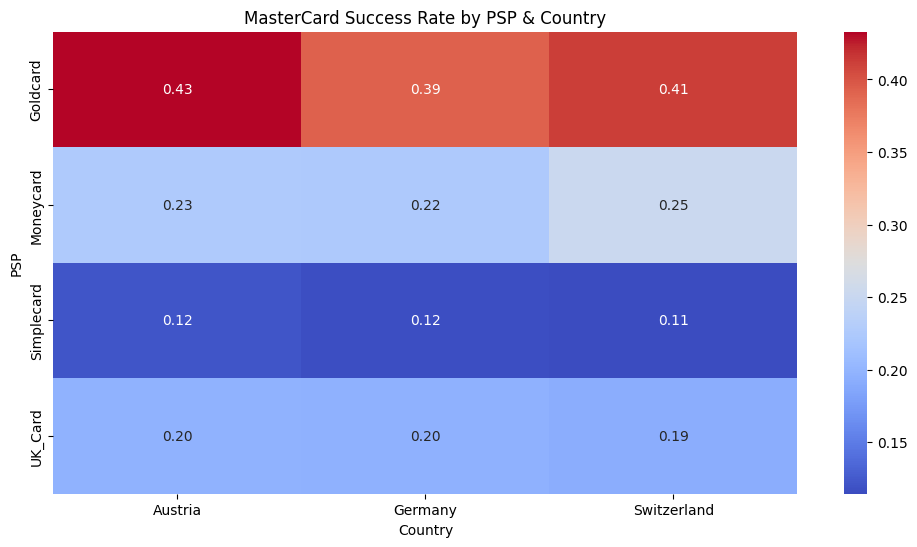

In [66]:
# MasterCard performance across countries for each PSP
# determine if MasterCard struggles more in certain countries due to PSP selection
mc_psp_country = data_cleaned[data_cleaned["card"] == "Master"].groupby(["PSP", "country"])["success"].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(mc_psp_country, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("MasterCard Success Rate by PSP & Country")
plt.xlabel("Country")
plt.ylabel("PSP")
plt.show()

In [67]:
mc_psp_country

country,Austria,Germany,Switzerland
PSP,,,
Goldcard,0.432927,0.392157,0.412088
Moneycard,0.225705,0.224234,0.251337
Simplecard,0.121849,0.115760,0.114494
UK_Card,0.197444,0.196460,0.191880


#### Observation

* The overall performance of Mastercard is best in Austria across all PSPs.
* MasterCard fails the most in Germany (worst success rates for all PSPs).
* Goldcard is the best PSP for MasterCard transactions in all countries (~40-43%).

💡 **Recommendation**:

* For MasterCard transactions in Germany, avoid UK_Card & Simplecard.
* If a transaction occurs in Austria, Goldcard is the best PSP option.

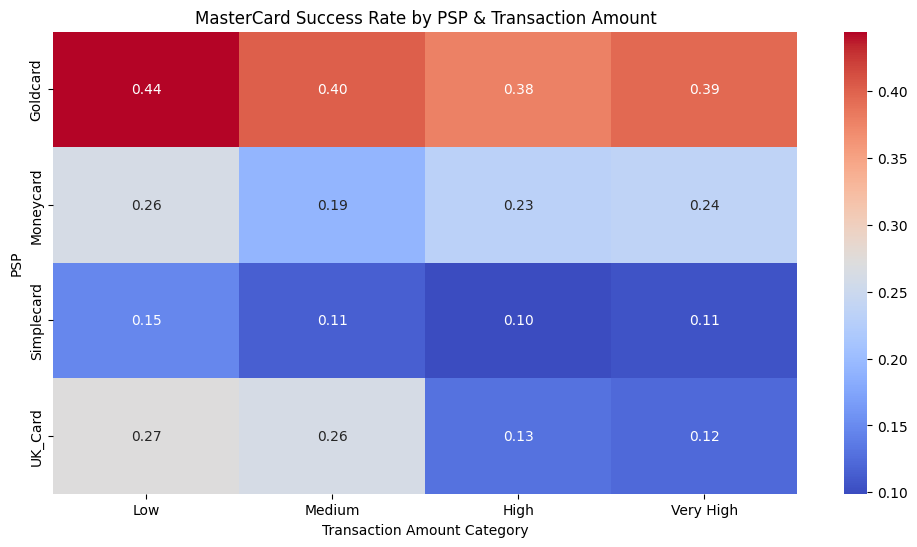

In [68]:
# Mastercard success rate by transaction amount for each PSP
# find out if MasterCard struggles with higher-value transactions more than other cards
# determine if specific PSPs handle high-value MasterCard transactions better.
mc_psp_amount_success = data_cleaned[data_cleaned["card"] == "Master"].groupby(["PSP", "amount_category"])["success"].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(mc_psp_amount_success, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("MasterCard Success Rate by PSP & Transaction Amount")
plt.xlabel("Transaction Amount Category")
plt.ylabel("PSP")
plt.show()

In [69]:
mc_psp_amount_success

amount_category,Low,Medium,High,Very High
PSP,,,,
Goldcard,0.444444,0.401316,0.377682,0.394737
Moneycard,0.261298,0.190751,0.231497,0.235945
Simplecard,0.146695,0.114781,0.098967,0.105077
UK_Card,0.271837,0.261136,0.129945,0.122295


#### Observation

* MasterCard transactions struggle the most at high-value transactions almost across all PSPs.
* UK_Card’s success rate drops sharply for High & Very High transactions (~12%).
* Goldcard is still the best choice for all transaction amounts.

💡 **Recommendation**:

* Never use UK_Card or Simplecard for Very High MasterCard transactions.
* For Very High transactions, prioritize Goldcard.

Hence,

1. MasterCard’s Low Success Rate is Largely Due to Poor PSP Selection
  * UK_Card (most used PSP) has a low success rate (~19.57%).
  * Simplecard (second most used PSP) is the worst (~11.67% success rate).
  * Goldcard (best-performing PSP) is underutilized (~40.39% success rate).

👉 **Solution:** Shift MasterCard transactions to Goldcard and reduce reliance on UK_Card & Simplecard.

2. Germany is the Worst-Performing Country for MasterCard Transactions
  * All PSPs perform worse for MasterCard transactions in Germany.
  * MasterCard performs best in Austria (~43.29% success rate with Goldcard).

👉 **Solution:** For MasterCard transactions in Germany, avoid UK_Card & Simplecard where possible.

3. High-Value MasterCard Transactions Fail the Most
  * UK_Card’s success rate for Very High transactions is only 12.23%.
  * Goldcard is the best PSP for High-Value transactions (~39.47%).

👉 **Solution:** Route High-Value MasterCard transactions through Goldcard.

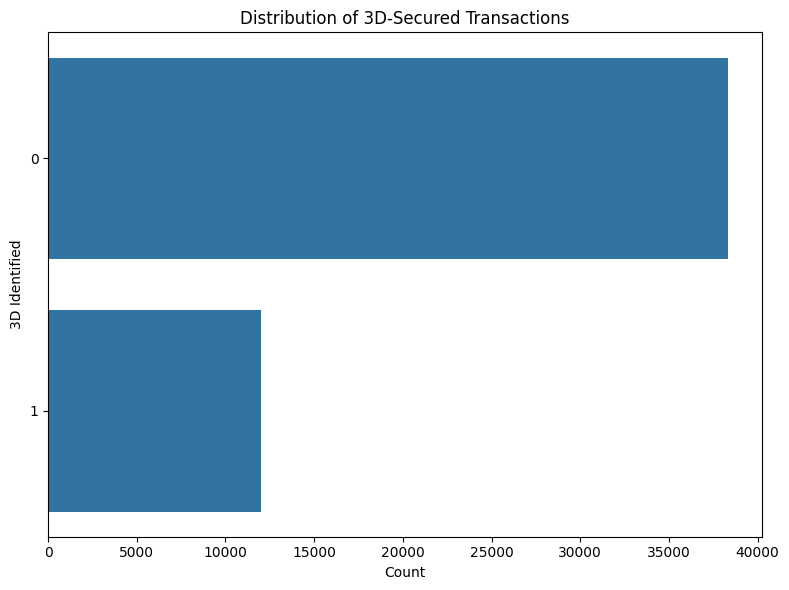

In [70]:
# analyzing distribution of 3D-Secured transactions
plt.figure(figsize=(8, 6))
sns.countplot(data=data_cleaned, y="3D_secured", order=data_cleaned["3D_secured"].value_counts().index)
plt.title("Distribution of 3D-Secured Transactions")
plt.xlabel("Count")
plt.ylabel("3D Identified")
plt.tight_layout()
plt.show()

In [71]:
print("% distribution of 3D-Secured transactions:\n")
print((data_cleaned["3D_secured"].value_counts() / len(data_cleaned) * 100).round(2))

% distribution of 3D-Secured transactions:

3D_secured
0    76.17
1    23.83
Name: count, dtype: float64


#### Observation

* Most transactions (~76%) are not 3D-Secured.
* Only ~24% of transactions use 3D-Secured authentication.

💡 **Recommendation**: Investigate why 3D-Secured is not widely adopted and whether increasing its usage can improve success rates.

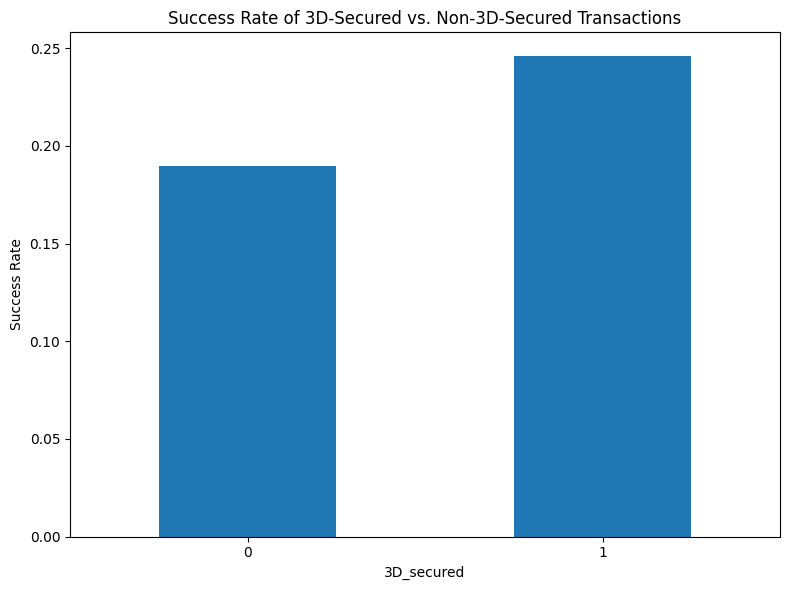

In [72]:
# analyzing success rate of 3D-Secured vs. Non-3D-Secured transactions

# success rate across 3D_secured transactions
secured_3d_success_rate = data_cleaned.groupby("3D_secured")["success"].mean()

plt.figure(figsize=(8, 6))
secured_3d_success_rate.sort_values().plot(kind="bar")
plt.title("Success Rate of 3D-Secured vs. Non-3D-Secured Transactions")
plt.xlabel("3D_secured")
plt.ylabel("Success Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [73]:
secured_3d_success_rate

3D_secured
0    0.189879
1    0.245873
Name: success, dtype: float64

In [74]:
print("Number of transactions done based on 3D_secured choice:\n")
print(data_cleaned["3D_secured"].value_counts())
print("\n------------------------------------")
print("The proportion of successes and failures based on 3D_secured choice:\n")
data_cleaned.groupby("3D_secured")["success"].value_counts(normalize=True)

Number of transactions done based on 3D_secured choice:

3D_secured
0    38335
1    11994
Name: count, dtype: int64

------------------------------------
The proportion of successes and failures based on 3D_secured choice:



3D_secured  success
0           0          0.810121
            1          0.189879
1           0          0.754127
            1          0.245873
Name: proportion, dtype: float64

#### Observation

* 3D-Secured transactions have a significantly higher success rate (~24.59%) than non-3D transactions (~18.99%).
* Non-3D-Secured transactions fail more often (~81% failure rate).

💡 **Recommendation**:
* **Prioritize 3D-Secured transactions** where possible to maximize success rates.

<Figure size 1200x600 with 0 Axes>

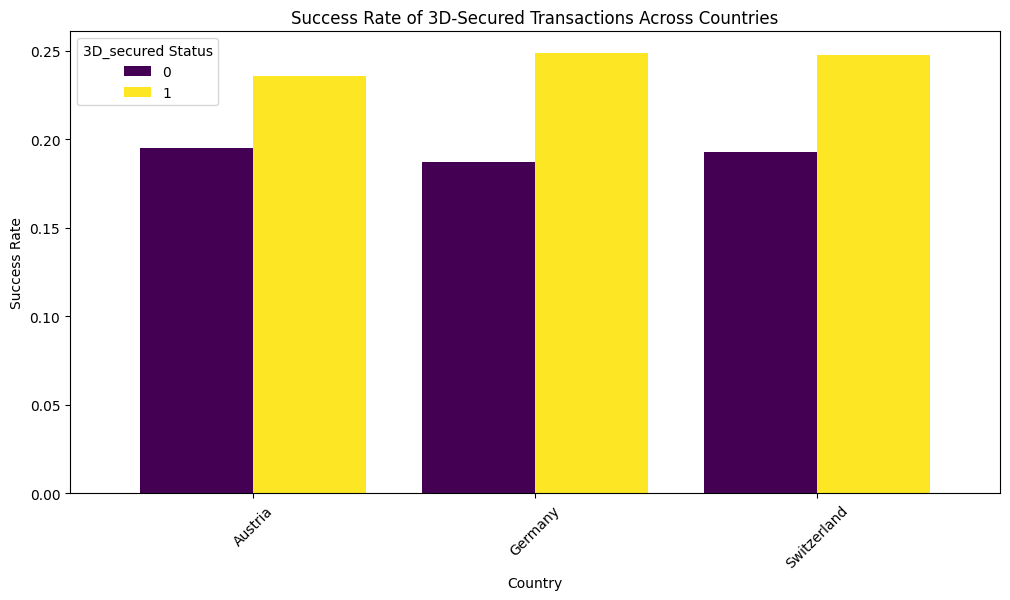

In [75]:
# analyzing success rate of 3D-Secured transactions across countries
secured_3d_country_success = data_cleaned.groupby(["3D_secured", "country"])["success"].mean().unstack()

plt.figure(figsize=(12, 6))
secured_3d_country_success.T.plot(kind="bar", figsize=(12, 6), colormap="viridis", width=0.8)
plt.title("Success Rate of 3D-Secured Transactions Across Countries")
plt.xlabel("Country")
plt.ylabel("Success Rate")
plt.xticks(rotation=45)
plt.legend(title="3D_secured Status")
plt.show()

In [76]:
secured_3d_country_success

country,Austria,Germany,Switzerland
3D_secured,,,
0,0.194895,0.187164,0.193103
1,0.235830,0.248599,0.247846


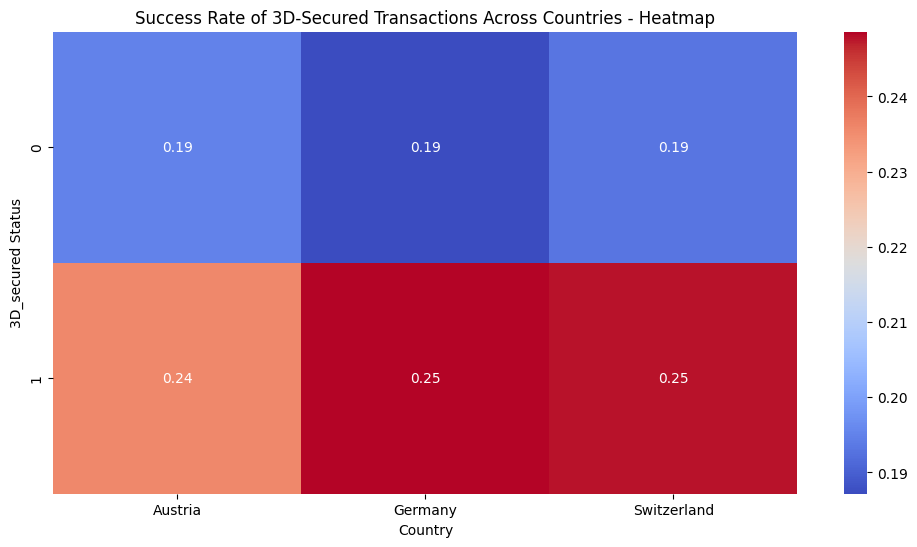

In [77]:
# Heatmap of 3D_secured status performance across countries
plt.figure(figsize=(12, 6))
sns.heatmap(secured_3d_country_success, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Success Rate of 3D-Secured Transactions Across Countries - Heatmap")
plt.xlabel("Country")
plt.ylabel("3D_secured Status")
plt.show()

#### Observation

* **In every country, 3D-Secured transactions significantly outperform non-3D transactions**.
* Germany has the worst success rate for non-3D-Secured transactions (~18.72%).
* 3D-Secured transactions in Germany outperform all other cases (~24.86%).

💡 **Recommendation**: Prioritize 3D-Secured transactions in all countries to boost success rates.

<Figure size 1200x600 with 0 Axes>

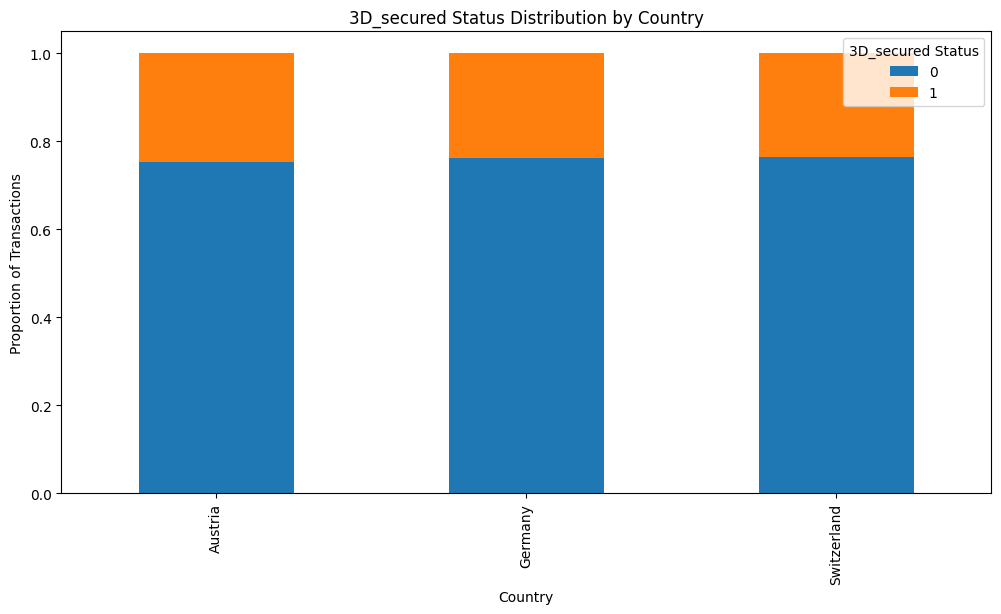

In [78]:
# compare 3D_secured status distribution across countries
secured_3d_distribution = data_cleaned.groupby("country")["3D_secured"].value_counts(normalize=True).unstack()

plt.figure(figsize=(12, 6))
secured_3d_distribution.plot(kind="bar", figsize=(12, 6), stacked=True)
plt.title("3D_secured Status Distribution by Country")
plt.xlabel("Country")
plt.ylabel("Proportion of Transactions")
plt.legend(title="3D_secured Status")
plt.show()

In [79]:
secured_3d_distribution

3D_secured,0,1
country,,
Austria,0.753895,0.246105
Germany,0.763451,0.236549
Switzerland,0.763948,0.236052


#### Observation

* Germany, despite benefiting the most from 3D-Secured authentication, has the low adoption rate.

💡 **Recommendation**: Increase 3D-Secured adoption in Germany, as it has the highest success rate boost.

<Figure size 1200x600 with 0 Axes>

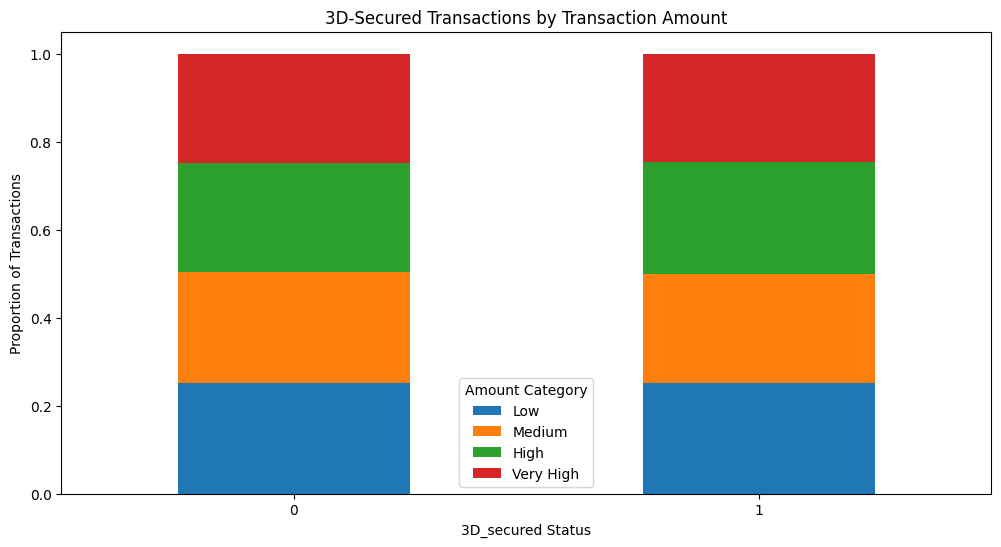

In [80]:
# compare 3D-Secured transactions by transaction amount
secured_3d_amount_distribution = data_cleaned.groupby("3D_secured")["amount_category"].value_counts(normalize=True).unstack()

plt.figure(figsize=(12, 6))
secured_3d_amount_distribution.plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("3D-Secured Transactions by Transaction Amount")
plt.xlabel("3D_secured Status")
plt.ylabel("Proportion of Transactions")
plt.legend(title="Amount Category")
plt.xticks(rotation=0)
plt.show()

In [81]:
secured_3d_amount_distribution

amount_category,Low,Medium,High,Very High
3D_secured,,,,
0,0.250633,0.253111,0.248546,0.247711
1,0.251876,0.247957,0.254294,0.245873


#### Observation

* 3D-Secured transactions are more common for High & Very High transactions.
* Non-3D-Secured transactions are slightly more frequent for Low & Medium amounts.

💡 **Recommendation**: **Encourage 3D-Secured authentication for Very High transactions** to improve success rates.

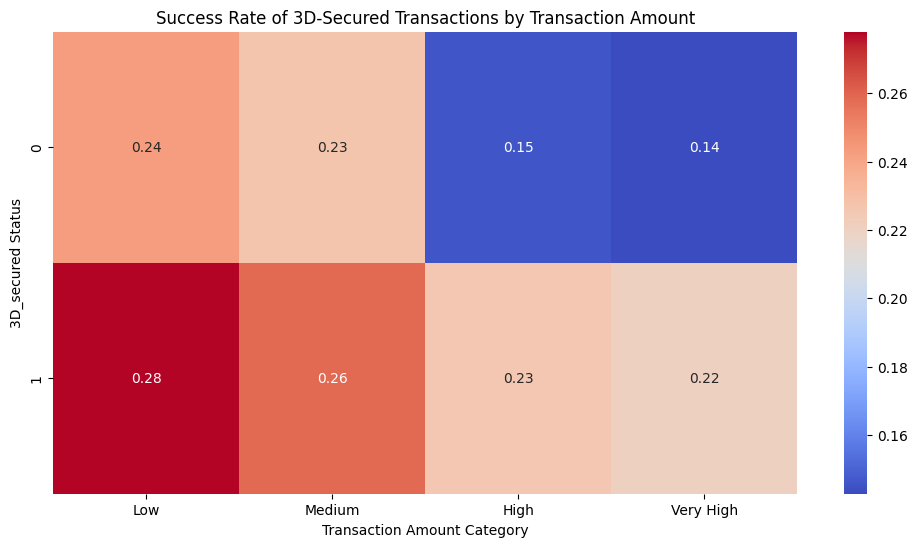

In [82]:
# analyse success rates bof 3D-Secured transactions by transaction amount
secured_3d_amount_success = data_cleaned.groupby(["3D_secured", "amount_category"])["success"].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(secured_3d_amount_success, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Success Rate of 3D-Secured Transactions by Transaction Amount")
plt.xlabel("Transaction Amount Category")
plt.ylabel("3D_secured Status")
plt.show()

In [83]:
secured_3d_amount_success

amount_category,Low,Medium,High,Very High
3D_secured,,,,
0,0.242714,0.227249,0.145466,0.142797
1,0.278054,0.258574,0.225902,0.220753


#### Observation

* For every transaction amount category, 3D-Secured transactions have higher success rates.
* For Very High transactions, 3D-Secured transactions have a nearly 8% higher success rate than non-3D transactions.

💡 **Recommendation**: Require 3D-Secured authentication for Very High transactions to improve success rates.

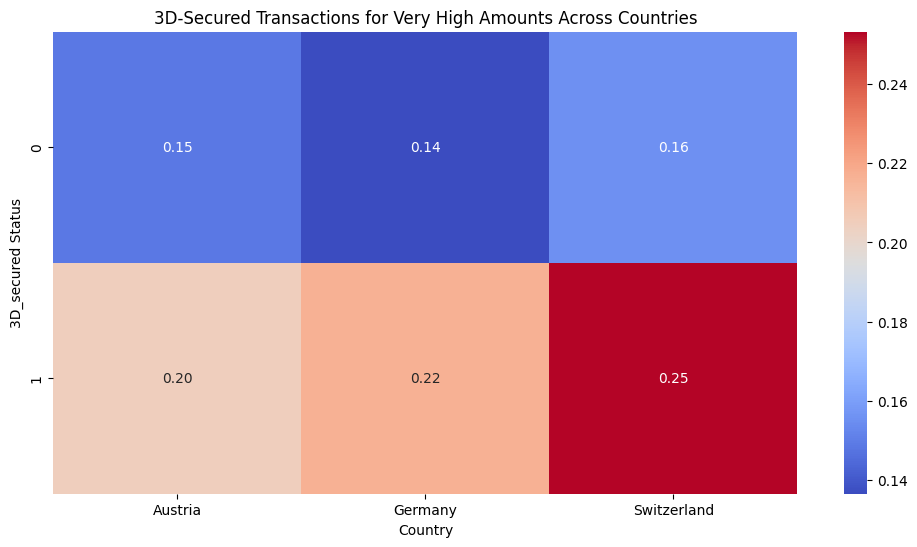

In [84]:
# compare 3D_secured transactions for very high amounts across countries
high_value_3d_secured_country = data_cleaned[data_cleaned["amount_category"] == "Very High"].groupby(["3D_secured", "country"])["success"].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(high_value_3d_secured_country, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("3D-Secured Transactions for Very High Amounts Across Countries")
plt.xlabel("Country")
plt.ylabel("3D_secured Status")
plt.show()

In [85]:
high_value_3d_secured_country

country,Austria,Germany,Switzerland
3D_secured,,,
0,0.148612,0.136531,0.155488
1,0.204762,0.216460,0.253211


#### Observation

* For Very High transactions, Switzerland has the highest success rate for 3D-Secured (~25.32%).
* Germany has the biggest success rate boost from 3D-Secured (~8% higher).

💡 **Recommendation**:
* For Very High transactions in Germany, enforce 3D-Secured authentication.
* For Switzerland, combine 3D-Secured + Goldcard + Visa to maximize success rates.

### 📌 Overall Conclusions: PSP + Card + 3D-Secured Impact on Success Rates

1. PSP Choice + Card Provider + 3D-Secured Together Determine Success Rate.
  
  ✅ **Best Combination: Goldcard + Diners + 3D-Secured** (highest success rate across all countries and transaction amounts).

  🚫 **Worst Combination: UK_Card + MasterCard + Non-3D-Secured** (lowest success rate, especially for high-value transactions).

  🚀 **Actions**:
  ✅ Prioritize 3D-Secured authentication where possible, especially for high-value transactions.
  
  ✅ Shift transactions away from UK_Card & Simplecard, especially for MasterCard transactions.

2. MasterCard Has the Lowest Success Rate, and 3D-Secured Can Help Improve It.
  * MasterCard transactions fail the most because they are routed through UK_Card & Simplecard (low-performing PSPs).
  * Goldcard performs best for MasterCard transactions (~40% success rate), but it is underutilized.
  * 3D-Secured significantly improves success rates for MasterCard transactions (~24.59% success rate vs. ~18.99% for non-3D transactions).

  🚀 **Actions**:
  ✅ Shift MasterCard transactions away from UK_Card & Simplecard and towards Goldcard & Moneycard.

  ✅ Enable 3D-Secured authentication for all MasterCard transactions to improve success rates.

3. Very High Transactions Have a Higher Failure Rate, So PSP + Card + 3D-Secured Selection is Critical.
  * UK_Card & Simplecard should not be used for Very High transactions (UK_Card ~12% success rate, Simplecard ~10%).
  * Goldcard is the best PSP for Very High transactions (~39%).
  * Diners has the best success rate for high-value transactions across all PSPs.
  * 3D-Secured significantly improves Very High transaction success rates (~22.07% success rate vs. ~14.28% for non-3D transactions).

  🚀 **Actions**:
  ✅ Route Very High transactions through Goldcard & Diners wherever possible.

  ✅ Require 3D-Secured authentication for all Very High transactions.

4. Germany Has the Lowest Success Rate Across All PSPs & Card Providers but 3D-Secured Helps.
  * All PSPs perform worse in Germany, especially for MasterCard transactions.
  * Goldcard is still the best-performing PSP in Germany, but its success rate is lower than in Austria & Switzerland.
  * Germany sees the biggest success rate boost from 3D-Secured (~8% improvement for Very High transactions).

  🚀 **Actions**:

  ✅ Avoid using UK_Card & Simplecard for transactions in Germany.
  
  ✅ Prefer Goldcard for MasterCard transactions in Germany.

  ✅ Require 3D-Secured authentication for all transactions in Germany to improve success rates.


5. Switzerland is the Best Country for Very High Transactions, Especially for Visa & 3D-Secured.
  * Visa performs best for Very High transactions in Switzerland (~20.7% success rate, better than MasterCard & Diners).
  * Goldcard is also the best PSP for high-value transactions in Switzerland.
  * Switzerland sees the biggest success rate for 3D-Secured transactions (~25.32% success rate for Very High transactions).

  🚀 **Actions**:

  ✅ If a Very High transaction occurs in Switzerland, route it through Visa + Goldcard.

  ✅ Encourage 3D-Secured authentication for all transactions in Switzerland to maximize success rates.

6. Diners Has the Best Overall Success Rate Across All Countries & Works Best with 3D-Secured.
  * Diners outperforms both MasterCard & Visa in every country and for every transaction amount.
  * It is the least used card provider (~19% of total transactions), meaning it is an underutilized opportunity.
  * 3D-Secured further improves Diners transactions' success rates across all amounts.

  🚀 **Actions**:
  
  ✅ Increase the use of Diners where possible, as it has the best success rate across all PSPs and countries.

  ✅ Encourage Diners transactions to use 3D-Secured authentication to maximize approval rates.

7. 3D-Secured Transactions Significantly Improve Success Rates for All Countries, PSPs & Transaction Amounts
  * 3D-Secured transactions outperform non-3D transactions in all countries (~24.59% success rate vs. ~18.99%).
  * 3D-Secured has the biggest success rate impact in Germany (~8% boost for Very High transactions).
  * For all PSPs, 3D-Secured transactions have a higher success rate than non-3D transactions.
  * For all transaction amounts, 3D-Secured transactions perform better (~8% improvement for Very High transactions).

  🚀 **Actions**:
  
  ✅ Enable 3D-Secured authentication for all Very High transactions.

  ✅ Prioritize 3D-Secured transactions for Germany & Switzerland.

In [86]:
# save the cleaned data
data_cleaned.to_csv("../data/processed/credit_card_routing_cleaned_data.csv", index=False)

In [87]:
# Sort by timestamp to help identify consecutive attempts
data_cleaned = data_cleaned.sort_values(by="tmsp").reset_index(drop=True)

# 4. Feature Engineering

In [88]:
# Identify repeated attempts within 1 minute, for same country & amount
data_cleaned['diff_seconds'] = data_cleaned.groupby(['country', 'amount'])['tmsp'].diff().dt.total_seconds()

In [89]:
# We define a new "purchase group" whenever:
#   - The time gap > 60 seconds, OR
#   - There is no previous transaction (NaN in diff_seconds)
data_cleaned['new_purchase'] = (data_cleaned['diff_seconds'] > 60) | (data_cleaned['diff_seconds'].isna())

In [90]:
# Create a cumulative purchase_id within each (country, amount) group
data_cleaned['purchase_id'] = data_cleaned.groupby(['country', 'amount'])['new_purchase'].cumsum()

In [91]:
# Create an "attempt_number" feature within each purchase_id
data_cleaned['attempt_number'] = data_cleaned.groupby('purchase_id').cumcount() + 1

In [92]:
# ------- Interaction Features (PSP, card, 3D, country, etc.) ---------

# PSP x Card
data_cleaned['psp_card'] = data_cleaned['PSP'] + '_' + data_cleaned['card']

# PSP x 3D_secured
# Convert 3D_secured to string so it can be concatenated
data_cleaned['psp_3d'] = data_cleaned['PSP'] + '_' + data_cleaned['3D_secured'].astype(str)

# Card x 3D_secured
data_cleaned['card_3d'] = data_cleaned['card'] + '_' + data_cleaned['3D_secured'].astype(str)

# PSP x Country
data_cleaned['psp_country'] = data_cleaned['PSP'] + '_' + data_cleaned['country']

# Card x Country
data_cleaned['card_country'] = data_cleaned['card'] + '_' + data_cleaned['country']

In [93]:
# Log Transform on Amount (to reduce right-skew)
data_cleaned['log_amount'] = np.log1p(data_cleaned['amount'])  # log(1 + amount)

In [94]:
# Time-based features from 'tmsp'
# For example, extract hour, day of week, etc.
data_cleaned['hour_of_day'] = data_cleaned['tmsp'].dt.hour
data_cleaned['day_of_week'] = data_cleaned['tmsp'].dt.dayofweek

In [95]:
# Drop temporary columns
data_cleaned.drop(columns=['diff_seconds', 'new_purchase'], inplace=True, errors='ignore')

In [96]:
data_cleaned.head(10)

,tmsp,country,amount,success,PSP,3D_secured,card,amount_category,purchase_id,attempt_number,psp_card,psp_3d,card_3d,psp_country,card_country,log_amount,hour_of_day,day_of_week
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,Low,1,1,UK_Card_Visa,UK_Card_0,Visa_0,UK_Card_Germany,Visa_Germany,4.499810,0,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,Low,1,2,UK_Card_Visa,UK_Card_0,Visa_0,UK_Card_Germany,Visa_Germany,4.499810,0,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,High,1,3,UK_Card_Diners,UK_Card_1,Diners_1,UK_Card_Germany,Diners_Germany,5.476464,0,1
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,High,1,4,UK_Card_Diners,UK_Card_1,Diners_1,UK_Card_Germany,Diners_Germany,5.476464,0,1
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,Low,1,5,Simplecard_Diners,Simplecard_0,Diners_0,Simplecard_Austria,Diners_Austria,4.828314,0,1
5,2019-01-01 00:06:41,Switzerland,282,0,UK_Card,0,Master,Very High,1,6,UK_Card_Master,UK_Card_0,Master_0,UK_Card_Switzerland,Master_Switzerland,5.645447,0,1
6,2019-01-01 00:07:19,Switzerland,282,0,Simplecard,0,Master,Very High,1,7,Simplecard_Master,Simplecard_0,Master_0,Simplecard_Switzerland,Master_Switzerland,5.645447,0,1
7,2019-01-01 00:08:46,Germany,117,1,UK_Card,0,Master,Low,1,8,UK_Card_Master,UK_Card_0,Master_0,UK_Card_Germany,Master_Germany,4.770685,0,1
8,2019-01-01 00:09:56,Switzerland,174,0,Simplecard,0,Visa,Medium,1,9,Simplecard_Visa,Simplecard_0,Visa_0,Simplecard_Switzerland,Visa_Switzerland,5.164786,0,1
9,2019-01-01 00:10:49,Switzerland,174,0,Simplecard,0,Visa,Medium,1,10,Simplecard_Visa,Simplecard_0,Visa_0,Simplecard_Switzerland,Visa_Switzerland,5.164786,0,1


#### Explanation

**Purchase Grouping (purchase_id)**:

- We sort by `tmsp`, then compute the time difference (`diff_seconds`) between consecutive transactions within (country, amount).
- If that difference exceeds 60 seconds or is NaN (the first transaction in a group), we mark a new purchase.
- We then cumsum that boolean to create a unique `purchase_id`.

**Attempt Number**:

- For each `purchase_id`, cumcount() will count how many transactions have occurred so far. Adding 1 starts the attempt numbering at 1.

**Interaction Features**:

- `psp_card`: Concatenates the PSP name and card provider. E.g., Goldcard_Visa.
- `psp_3d`: PSP + 3D_secured flag. E.g., Moneycard_1.
- `card_3d`: Card + 3D_secured.
- `psp_country`: PSP + Country.
- `card_country`: Card + Country.
- Such combined features can be powerful for capturing synergy effects.

**Log Transform**:

- `log_amount = log(1 + amount)` helps reduce skew if you plan on using linear models or distance-based methods.
- For tree-based models, we may not strictly need the transform, but it can still help.

**Time-Based Features**:

- Extract hour_of_day, day_of_week from tmsp.
- Helps capture daily/weekly patterns in transaction or PSP performance.

In [97]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50329 entries, 0 to 50328
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tmsp             50329 non-null  datetime64[ns]
 1   country          50329 non-null  object        
 2   amount           50329 non-null  int64         
 3   success          50329 non-null  int64         
 4   PSP              50329 non-null  object        
 5   3D_secured       50329 non-null  int64         
 6   card             50329 non-null  object        
 7   amount_category  50329 non-null  category      
 8   purchase_id      50329 non-null  int64         
 9   attempt_number   50329 non-null  int64         
 10  psp_card         50329 non-null  object        
 11  psp_3d           50329 non-null  object        
 12  card_3d          50329 non-null  object        
 13  psp_country      50329 non-null  object        
 14  card_country     50329 non-null  objec

## Avoid Data Leakage: Split Before Encoding

In [98]:
# Let's say anything in January (tmsp < 2019-02-01) is train, and anything in February is test
train_data = data_cleaned[data_cleaned['tmsp'] < '2019-02-01'].copy()
test_data  = data_cleaned[data_cleaned['tmsp'] >= '2019-02-01'].copy()

In [99]:
print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (26270, 18)
Test shape: (24059, 18)


In [100]:
train_data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,amount_category,purchase_id,attempt_number,psp_card,psp_3d,card_3d,psp_country,card_country,log_amount,hour_of_day,day_of_week
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,Low,1,1,UK_Card_Visa,UK_Card_0,Visa_0,UK_Card_Germany,Visa_Germany,4.499810,0,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,Low,1,2,UK_Card_Visa,UK_Card_0,Visa_0,UK_Card_Germany,Visa_Germany,4.499810,0,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,High,1,3,UK_Card_Diners,UK_Card_1,Diners_1,UK_Card_Germany,Diners_Germany,5.476464,0,1
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,High,1,4,UK_Card_Diners,UK_Card_1,Diners_1,UK_Card_Germany,Diners_Germany,5.476464,0,1
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,Low,1,5,Simplecard_Diners,Simplecard_0,Diners_0,Simplecard_Austria,Diners_Austria,4.828314,0,1


## Encoding Categorical Features

In [101]:
def preprocess_data(train_data, test_data, label_encode_columns, one_hot_encode_columns, numeric_feats, target_col='success'):
    """
    Preprocesses train and test datasets by applying Label Encoding, One-Hot Encoding, and preparing the final feature sets.

    Parameters:
        train_data (pd.DataFrame): The training dataset.
        test_data (pd.DataFrame): The testing dataset.
        label_encode_columns (list): List of column names to be label-encoded.
        one_hot_encode_columns (list): List of categorical column names for one-hot encoding.
        numeric_feats (list): List of numerical features to be included.
        target_col (str): The name of the target variable.

    Returns:
        X_train (pd.DataFrame): Processed training feature set.
        X_test (pd.DataFrame): Processed testing feature set.
        y_train (pd.Series): Target values for training.
        y_test (pd.Series): Target values for testing.
    """
    # Label Encoding for specified columns
    label_encoder = LabelEncoder()
    for col in label_encode_columns:
        train_data[f'{col}_le'] = label_encoder.fit_transform(train_data[col])
        test_data[f'{col}_le'] = label_encoder.transform(test_data[col])

    # One-Hot Encoding for categorical features
    ohe = OneHotEncoder(drop='first', sparse_output=False)  # drop='first' to avoid multicollinearity
    ohe.fit(train_data[one_hot_encode_columns])

    X_train_cat = ohe.transform(train_data[one_hot_encode_columns])
    X_test_cat = ohe.transform(test_data[one_hot_encode_columns])

    # Convert to DataFrame for easier concatenation
    ohe_col_names = ohe.get_feature_names_out(one_hot_encode_columns)
    X_train_cat_df = pd.DataFrame(X_train_cat, columns=ohe_col_names, index=train_data.index)
    X_test_cat_df = pd.DataFrame(X_test_cat, columns=ohe_col_names, index=test_data.index)

    # Numeric Features
    X_train_num = train_data[numeric_feats].copy()
    X_test_num = test_data[numeric_feats].copy()

    # Final Feature Set
    X_train = pd.concat([X_train_num, X_train_cat_df], axis=1)
    X_test = pd.concat([X_test_num, X_test_cat_df], axis=1)

    # Target Variable
    y_train = train_data[target_col]
    y_test = test_data[target_col]

    return X_train, X_test, y_train, y_test

In [102]:
# Define feature sets
label_encode_columns = ['psp_card', 'psp_3d', 'card_3d', 'psp_country', 'card_country']
one_hot_encode_columns = ['country', 'card', 'amount_category']
numeric_feats = ['log_amount', 'hour_of_day', 'day_of_week', 'attempt_number', '3D_secured',
                 'psp_card_le', 'psp_3d_le', 'card_3d_le', 'psp_country_le', 'card_country_le']

In [103]:
# Apply function
X_train, X_test, y_train, y_test = preprocess_data(train_data, test_data, label_encode_columns, one_hot_encode_columns, numeric_feats)

In [104]:
# Create a dictionary for label encoders for future reference
my_label_encoders = {}

for col in label_encode_columns:
    le = LabelEncoder()
    le.fit(pd.concat([train_data[col], test_data[col]]))  # Fit on combined for consistency
    my_label_encoders[col] = le

print(my_label_encoders)

{'psp_card': LabelEncoder(), 'psp_3d': LabelEncoder(), 'card_3d': LabelEncoder(), 'psp_country': LabelEncoder(), 'card_country': LabelEncoder()}


In [105]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (26270, 17)
y_train shape: (26270,)


In [106]:
X_train.head()

,log_amount,hour_of_day,day_of_week,attempt_number,3D_secured,psp_card_le,psp_3d_le,card_3d_le,psp_country_le,card_country_le,country_Germany,country_Switzerland,card_Master,card_Visa,amount_category_Low,amount_category_Medium,amount_category_Very High
0,4.499810,0,1,1,0,11,6,4,10,7,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,4.499810,0,1,2,0,11,6,4,10,7,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,5.476464,0,1,3,1,9,7,1,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.476464,0,1,4,1,9,7,1,10,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.828314,0,1,5,0,6,4,0,6,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [107]:
y_train.head()

0    0
1    1
2    0
3    1
4    0
Name: success, dtype: int64

## Handling Imbalanced Target

In [108]:
y_train.value_counts()

success
0    20948
1     5322
Name: count, dtype: int64

In [109]:
# SMOTE oversampling on the training set only
sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", X_train.shape, y_train.value_counts())
print("After SMOTE:", X_train_res.shape, y_train_res.value_counts())

Before SMOTE: (26270, 17) success
0    20948
1     5322
Name: count, dtype: int64
After SMOTE: (41896, 17) success
0    20948
1    20948
Name: count, dtype: int64


# 5. Feature Selection

In [110]:
# Define the selector
k = 10  # pick top 10 features
selector = SelectKBest(score_func=f_classif, k=k)

In [111]:
# Fit on training data
selector.fit(X_train_res, y_train_res)

SelectKBest()

In [112]:
# Transform both train and test
X_train_selected = selector.transform(X_train_res)
X_test_selected  = selector.transform(X_test)

In [113]:
# Check which columns were selected
mask = selector.get_support()  # Boolean mask of selected features
selected_feature_names = X_train.columns[mask]
print("Selected Features:", selected_feature_names)

Selected Features: Index(['log_amount', '3D_secured', 'psp_card_le', 'psp_3d_le', 'card_3d_le',
       'psp_country_le', 'card_country_le', 'amount_category_Low',
       'amount_category_Medium', 'amount_category_Very High'],
      dtype='object')


In [114]:
# The PSP fees structure
fee_success = {'Moneycard': 5, 'Goldcard': 10, 'UK_Card': 3, 'Simplecard': 1}
fee_fail    = {'Moneycard': 2, 'Goldcard': 5,  'UK_Card': 1, 'Simplecard': 0.5}

# 6. Modeling

## 6.1 Baseline Model

A baseline could be something like **always pick** `UK_Card` (most-used in your data), or **always pick** `Goldcard` (highest success rate historically). We’ll calculate the expected cost and success metrics assuming all transactions go through that PSP.

In [115]:
def baseline_always_uk_card(df_test, fee_success, fee_fail):
    """
    Implements a baseline strategy where all transactions are assumed to be routed through 'UK_Card'
    and calculates the expected cost based on historical success rates.

    Parameters:
        df_test (pd.DataFrame):
            The test dataset containing the 'success' column, representing the actual transaction
            outcome for the PSP that was historically used.
        fee_success (dict):
            Dictionary containing the transaction fee for successful payments per PSP.
        fee_fail (dict):
            Dictionary containing the transaction fee for failed payments per PSP.

    Returns:
        pd.DataFrame:
            A modified version of df_test with an additional column:
            - 'chosen_psp': Set to 'UK_Card' for all transactions.
            - 'baseline_cost': The cost incurred assuming all transactions used 'UK_Card'.
    """

    # Create a copy of df_test to avoid modifying the original dataset
    df_test = df_test.copy()

    # Assume all transactions are routed through 'UK_Card'
    df_test['chosen_psp'] = 'UK_Card'

    # Determine the transaction cost based on historical success/failure
    # If a transaction was successful (success = 1), assign the success fee
    # Otherwise, assign the failure fee
    df_test['baseline_cost'] = np.where(
        df_test['success'] == 1,
        fee_success.get('UK_Card', 0),  # Default to 0 if 'UK_Card' key is missing
        fee_fail.get('UK_Card', 0)      # Default to 0 if 'UK_Card' key is missing
    )

    return df_test

In [116]:
# Let's create a copy of X_test to combine with y_test for easy reference
test_df_for_baseline = X_test.copy()
test_df_for_baseline['success'] = y_test.values
test_df_for_baseline = baseline_always_uk_card(test_df_for_baseline, fee_success, fee_fail)

In [117]:
# Summarize
avg_cost = test_df_for_baseline['baseline_cost'].mean()
success_rate = test_df_for_baseline['success'].mean()  # how many were actually successful
print(f"Baseline (Always UK_Card) - Avg Cost: {avg_cost:.2f}, Success Rate: {success_rate:.2%}")

Baseline (Always UK_Card) - Avg Cost: 1.41, Success Rate: 20.39%


#### Observation

* **Success Rate: 20.39%**

  Out of all transactions in your test set, if you always pick the PSP “UK_Card,” about 20.39% of them succeed. This matches the actual success label in the dataset assuming we replicate the historical success/failure pattern when UK_Card was used.

* **Avg Cost: 1.41**

  On average, each transaction costs 1.41 in PSP fees (factoring both successes and failures).

* If we computed “Cost per Success,” it would be roughly (Avg Cost)/(Success Rate). For example, if in 100 transactions each cost 1.41 on average, total cost is 141. Over 20 successes, that’s about 141 / 20 = 7.05 per success.

This is your naive reference point. If our predictive model can beat a 20.39% success rate while reducing average costs below 1.41, we have a better strategy than “always UK_Card.”

## 6.2 Predictive Model: Expected Cost/Benefit Approach

* Rather than having one “named” model, we will actually be using a combination of multiple binary classifiers—one per Payment Service Provider (PSP). We can think of it as a “PSP Routing Model” or “PSP Decision Engine.”
* Each PSP has different success/fail patterns and different fees for successes/failures. By training a separate binary classifier (e.g., RandomForest, LightGBM, etc.) for each PSP, we can estimate: P(success∣transaction,PSP=p). This is the probability of success if that transaction is routed to PSP p.


### 6.2.1 Train 4 Separate Binary Classifiers
We’ll train 4 models on the SMOTE-resampled training data, but each model is only fit on rows that used that PSP historically. This way, we learn P(success|X, PSP). Then we can compute expected cost for each PSP at inference time.

In [118]:
PSPs = ["Moneycard", "Goldcard", "UK_Card", "Simplecard"]

In [119]:
psp_models = {}
metrics_dict = {}

In [120]:
# we re-attach PSP info to the SMOTE-resampled data.
# Typically, you'd do the SMOTE on the subset per PSP, but let's illustrate a simpler approach:
# Step 1: We'll create a combined train DataFrame from X_train_res + PSP column from the original train set.
train_df_res = pd.DataFrame(X_train_res, columns=selected_feature_names)
train_df_res['success'] = y_train_res.values

In [121]:
# We need the 'PSP' from the original training set prior to SMOTE.
# But SMOTE changes indices. So either we do "4 separate SMOTEs" or we do a workaround:
# The "correct" method is: for each PSP, subset original X_train, y_train -> SMOTE -> train.
# Let's do that approach below.
for psp in PSPs:
    # Subset the original (non-SMOTE) training set where PSP == psp
    # Because we only have success/fail for that PSP
    mask = (train_data['PSP'] == psp)
    X_train_psp = X_train.loc[mask, selected_feature_names].copy()
    y_train_psp = y_train.loc[mask].copy()

    # SMOTE on each PSP subset
    if len(y_train_psp) == 0:
        # No training data for that PSP in train set, skip
        continue

    # SMOTE for this PSP subset
    sm_psp = SMOTE(random_state=42)
    X_train_psp_res, y_train_psp_res = sm_psp.fit_resample(X_train_psp, y_train_psp)

    # Train a basic RandomForest
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_psp_res, y_train_psp_res)

    # Evaluate on test subset that used this PSP historically
    test_mask = (test_data['PSP'] == psp)
    X_test_psp = X_test.loc[test_mask, selected_feature_names]
    y_test_psp = y_test.loc[test_mask]

    if len(y_test_psp) > 0:
        y_pred = clf.predict(X_test_psp)
        prec = precision_score(y_test_psp, y_pred, zero_division=0)
        rec = recall_score(y_test_psp, y_pred, zero_division=0)
        f1 = f1_score(y_test_psp, y_pred, zero_division=0)
        metrics_dict[psp] = {'precision': prec, 'recall': rec, 'f1': f1}

    psp_models[psp] = clf

In [122]:
print("PSP-specific classification metrics on the portion of test data:")
for psp, m in metrics_dict.items():
    print(f"{psp} -> Precision={m['precision']:.2f}, Recall={m['recall']:.2f}, F1={m['f1']:.2f}")

PSP-specific classification metrics on the portion of test data:
Moneycard -> Precision=0.25, Recall=0.37, F1=0.30
Goldcard -> Precision=0.47, Recall=0.50, F1=0.48
UK_Card -> Precision=0.24, Recall=0.39, F1=0.30
Simplecard -> Precision=0.18, Recall=0.33, F1=0.24


#### Observation

* These are the F1 scores for each PSP’s binary classifier on that PSP’s portion of test data.
* Goldcard stands out with an F1 of ~0.48, better than the others. Moneycard and UK_Card are around 0.30; Simplecard is the lowest at 0.24.
* It shows that, on PSP-specific subsets, the models are moderately predictive.

### 6.2.2 Inference & PSP Selection (Test Set)

At inference time (each row in X_test), we’ll:

1. **Compute success probability** for each of the 4 PSP models.

2. **Calculate expected cost** = `p_success * fee_success + (1 - p_success) * fee_fail`.

3. **Pick the PSP** with the **lowest expected cost**.

4. For evaluation, we do a **theoretical** approach: we’ll assume the success/fail in test was the same as the ground-truth label if the chosen PSP = the historically used PSP. For other PSPs, we only have the model’s predicted probability.

**Caution**: Because we don’t have real outcomes for transactions that used a different PSP historically, we can only simulate or rely on the model’s predicted success probability. Below, we do a naive simulation.

In [123]:
# ========== SINGLE-ATTEMPT ROUTING SIMULATION ==========
def select_best_psp(row, psp_models, fee_success, fee_fail):
    """
    Selects the optimal Payment Service Provider (PSP) for a given transaction
    to minimize transaction costs while maximizing success probability.

    Parameters:
        row (pd.Series): A single row (1D vector) of features from X_test.
        psp_models (dict): A dictionary mapping each PSP to its trained model.
        fee_success (dict): A dictionary containing the transaction fee for successful transactions per PSP.
        fee_fail (dict): A dictionary containing the transaction fee for failed transactions per PSP.

    Returns:
        tuple: (best_psp, best_expected_cost, success_prob_of_best)
            - best_psp (str): The PSP with the lowest expected cost.
            - best_expected_cost (float): The minimum expected cost for the transaction.
            - success_prob_of_best (float): The probability of success for the selected PSP.
    """
    best_psp = None  # Store the best PSP with the lowest expected cost
    best_expected_cost = float('inf')  # Initialize with a high cost
    best_success_prob = 0.0  # Store the highest success probability

    # Iterate through available PSP models
    for psp, model in psp_models.items():
        # Predict the probability of success for the given PSP
        success_prob = model.predict_proba(row.values.reshape(1, -1))[0][1]

        # Compute expected cost: success cost * success probability + failure cost * failure probability
        expected_cost = success_prob * fee_success[psp] + (1 - success_prob) * fee_fail[psp]

        # Update the best PSP selection if a lower expected cost is found
        if expected_cost < best_expected_cost:
            best_expected_cost = expected_cost
            best_psp = psp
            best_success_prob = success_prob

    return best_psp, best_expected_cost, best_success_prob

In [124]:
# List to store simulation results
results = []

# Iterate over each transaction in the test dataset
for idx in X_test.index:
    # Extract the feature vector for the current transaction
    row = X_test.loc[idx, selected_feature_names]

    # Select the best PSP based on expected cost and success probability
    chosen_psp, exp_cost, success_prob = select_best_psp(row, psp_models, fee_success, fee_fail)

    # Retrieve actual historical data for reference
    actual_success = y_test.loc[idx]  # The actual success outcome in the dataset
    historical_psp = test_data.loc[idx, 'PSP']  # The PSP originally used for the transaction

    # Simulating success:
    # If the selected PSP matches the historical PSP, we use the actual recorded outcome.
    # Otherwise, we "simulate" the success outcome using the predicted success probability.
    if chosen_psp == historical_psp:
        success_sim = actual_success  # Use actual recorded success
    else:
        # Simulate success using the model’s probability (thresholding at 0.5)
        success_sim = int(success_prob >= 0.5)

    # Determine the simulated cost based on success outcome
    sim_cost = fee_success[chosen_psp] if success_sim == 1 else fee_fail[chosen_psp]

    # Store the results for analysis
    results.append({
        'transaction_id': idx,       # Unique transaction identifier
        'chosen_psp': chosen_psp,     # The PSP selected by the model
        'historical_psp': historical_psp,  # The PSP that was originally used
        'success_prob': success_prob, # Predicted probability of success
        'actual_success': actual_success,  # Actual success (if available)
        'simulated_success': success_sim,  # Simulated success outcome
        'expected_cost': exp_cost,    # Expected transaction cost
        'simulated_cost': sim_cost    # Simulated transaction cost
    })

In [125]:
results_df = pd.DataFrame(results)

In [126]:
results_df.head()

,transaction_id,chosen_psp,historical_psp,success_prob,actual_success,simulated_success,expected_cost,simulated_cost
0,26270,Simplecard,UK_Card,0.313333,0,0,0.656667,0.5
1,26271,Simplecard,UK_Card,0.578333,0,1,0.789167,1.0
2,26272,Simplecard,UK_Card,0.578333,0,1,0.789167,1.0
3,26273,Simplecard,Goldcard,0.630833,0,1,0.815417,1.0
4,26274,Simplecard,UK_Card,0.403833,1,0,0.701917,0.5


### 6.2.3 Evaluate the Predictive Routing Strategy

Now we can compute:

* **Payment Success Rate** (the fraction of transactions that “succeeded” in our simulation).
* **Cost Efficiency** or **Cost per Success**.
* **Precision**, **Recall**, **F1** (though these are tricky with a simulated success outcome for changed PSPs).

In [127]:
# ---- Payment Success Rate in the simulation ----

# "success_rate" is renamed to "success_rate_single"
success_rate_single = results_df['simulated_success'].mean()

# "avg_cost" is renamed to "avg_cost_single"
avg_cost_single = results_df['simulated_cost'].mean()

# "successes" is renamed to "successes_single"
successes_single = results_df['simulated_success'].sum()

# "cost_per_success" is renamed to "cost_per_success_single"
if successes_single > 0:
    cost_per_success_single = results_df['simulated_cost'].sum() / successes_single
else:
    cost_per_success_single = np.nan

# print(f"Predicted Routing Strategy:")
print("\n--- Single-Attempt Predictive Routing ---")
print(f" - Simulated Payment Success Rate: {success_rate_single:.2%}")
print(f" - Average Cost: {avg_cost_single:.2f}")
print(f" - Cost per Success: {cost_per_success_single:.2f}")


--- Single-Attempt Predictive Routing ---
 - Simulated Payment Success Rate: 21.65%
 - Average Cost: 0.61
 - Cost per Success: 2.81


#### Observation

* Compared to the baseline success rate (20.39%) and cost (1.41), the model-based approach yields a +1% improvement in success rate, but drastically lower average cost (0.61).
* We’re effectively choosing cheaper PSPs whenever the success probability is high enough, thus saving on fees.

In [128]:
# ===================================== MULTIPLE ATTEMPTS SIMULATION PROCESS =====================================
def simulate_purchase(purchase_df, psp_models, fee_success, fee_fail, feature_cols):
    """
    Simulates a multiple-attempts payment scenario, where the model selects the best PSP
    based on success probability and expected cost for each attempt.

    Parameters:
        purchase_df (pd.DataFrame): The subset of transaction attempts for a single purchase.
        psp_models (dict): Dictionary of PSP models where keys are PSP names and values are trained models.
        fee_success (dict): Dictionary mapping each PSP to its transaction fee on success.
        fee_fail (dict): Dictionary mapping each PSP to its transaction fee on failure.
        feature_cols (list): List of feature column names used for PSP prediction.

    Returns:
        dict: A dictionary containing:
            - 'purchase_id' (int): Unique purchase identifier.
            - 'final_success' (int): 1 if transaction succeeds, 0 otherwise.
            - 'total_fee' (float): Cumulative transaction fee across attempts.
            - 'attempts_used' (int): Number of attempts made before success or failure.
    """
    total_fee = 0.0  # Track total transaction fees
    success_flag = 0  # 1 if transaction succeeds, else 0
    attempt_count = 0  # Count number of attempts

    # Iterate through each attempt for a given purchase
    for idx, row in purchase_df.iterrows():
        attempt_count += 1  # Increment attempt counter
        x_row = row[feature_cols].values.reshape(1, -1)  # Extract features for prediction

        # Select the best PSP based on minimum expected cost
        best_psp = None
        best_ecost = float('inf')  # Initialize with a high value
        best_success_prob = 0.0  # Store the best PSP's predicted success probability

        for psp, model in psp_models.items():
            prob_success = model.predict_proba(x_row)[0][1]  # Probability of transaction success
            expected_cost = (prob_success * fee_success[psp]) + ((1 - prob_success) * fee_fail[psp])

            # Select PSP with the lowest expected cost
            if expected_cost < best_ecost:
                best_ecost = expected_cost
                best_psp = psp
                best_success_prob = prob_success

        # Simulate transaction success using probability thresholding
        success_simulated = 1 if np.random.rand() < best_success_prob else 0

        # Calculate the fee based on success or failure
        fee = fee_success[best_psp] if success_simulated == 1 else fee_fail[best_psp]
        total_fee += fee  # Update total transaction fee

        # If successful, stop further attempts
        if success_simulated == 1:
            success_flag = 1
            break

    # Return simulation results
    return {
        'purchase_id': purchase_df['purchase_id'].iloc[0],
        'final_success': success_flag,
        'total_fee': total_fee,
        'attempts_used': attempt_count
    }

In [129]:
# Step 1: Prepare test data
# Ensure test data is sorted by purchase ID and attempt number
test_data_sorted = test_data.sort_values(by=['purchase_id', 'attempt_number']).copy()

# Extract selected features for test data
test_data_sorted_feats = X_test[selected_feature_names].copy()

# Merge sorted test data with corresponding features
all_test_df = test_data_sorted.merge(
    test_data_sorted_feats,
    left_index=True,
    right_index=True,
    how='left',
    suffixes=("", "_feat")  # Avoid column name conflicts
)

In [130]:
# Step 2: Run multiple-attempts simulation
simulation_results = []

# Group transactions by purchase ID to simulate purchase attempts separately
for purchase_id, purchase_group in all_test_df.groupby('purchase_id'):
    outcome = simulate_purchase(purchase_group, psp_models, fee_success, fee_fail, selected_feature_names)
    simulation_results.append(outcome)

In [132]:
# Step 3: Store results in a DataFrame
multi_attempts_df = pd.DataFrame(simulation_results)

# Step 4: Compute performance metrics
final_success_rate = multi_attempts_df['final_success'].mean()
average_fee = multi_attempts_df['total_fee'].mean()
cost_per_success = multi_attempts_df['total_fee'].sum() / multi_attempts_df['final_success'].sum()

# Step 5: Print simulation results
print("\n--- Multiple-Attempts Simulation ---")
print(f"Final Success Rate: {final_success_rate:.2%}")
print(f"Average Fee per Purchase: {average_fee:.2f}")
print(f"Cost per Success: {cost_per_success:.2f}")


--- Multiple-Attempts Simulation ---
Final Success Rate: 97.50%
Average Fee per Purchase: 1.75
Cost per Success: 1.79


#### Observation

* By allowing multiple attempts (trying a new PSP if the first attempt “fails”), we get a very high final success rate (97.5%).
* The average fee is 1.75—higher than the single-attempt approach, because we’re paying multiple fees for repeated attempts.
* Still, the cost per success is a reasonable 1.79. This is much lower than the baseline cost per success (~7.0 if you do the math for “always UK_Card”). It is also lower than single-attempt approach.

# 7. Model Evaluation: AUC, Confusion Matrix

In [133]:
def evaluate_psp_models(psp_models, X_test, y_test, test_data, selected_feature_names):
    """
    Evaluates a set of PSP models on test data by calculating AUC scores,
    plotting ROC curves, and displaying confusion matrices.

    Parameters:
        psp_models (dict): Dictionary where keys are PSP names and values are trained models.
        X_test (pd.DataFrame): The feature matrix for the test set.
        y_test (pd.Series): The true labels for the test set.
        test_data (pd.DataFrame): The full test dataset containing the 'PSP' column.
        selected_feature_names (list): List of selected feature names used for model prediction.

    Returns:
        None: The function prints AUC scores, plots ROC curves, and displays confusion matrices.
    """

    print("\n=== PSP Model Evaluation: AUC/ROC & Confusion Matrices ===")

    for psp, model in psp_models.items():
        # Filter test data for the given PSP
        mask = (test_data['PSP'] == psp)
        X_test_psp = X_test.loc[mask, selected_feature_names]
        y_test_psp = y_test.loc[mask]

        # Skip if there are no test samples for this PSP
        if len(y_test_psp) == 0:
            print(f"Skipping PSP {psp}: No test samples available.")
            continue

        # Predict probabilities and labels
        y_score = model.predict_proba(X_test_psp)[:, 1]
        y_pred = model.predict(X_test_psp)

        # Calculate AUC Score
        auc_score = roc_auc_score(y_test_psp, y_score)
        fpr, tpr, _ = roc_curve(y_test_psp, y_score)
        print(f"{psp} AUC: {auc_score:.3f}")

        # Plot ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, label=f"{psp} (AUC={auc_score:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
        plt.title(f"ROC Curve: {psp}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

        # Compute and display Confusion Matrix
        cm = confusion_matrix(y_test_psp, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
        disp.plot()
        plt.title(f"Confusion Matrix: {psp}")
        plt.show()


=== PSP Model Evaluation (Random Forest): AUC/ROC & Confusion Matrices ===

=== PSP Model Evaluation: AUC/ROC & Confusion Matrices ===
Moneycard AUC: 0.538


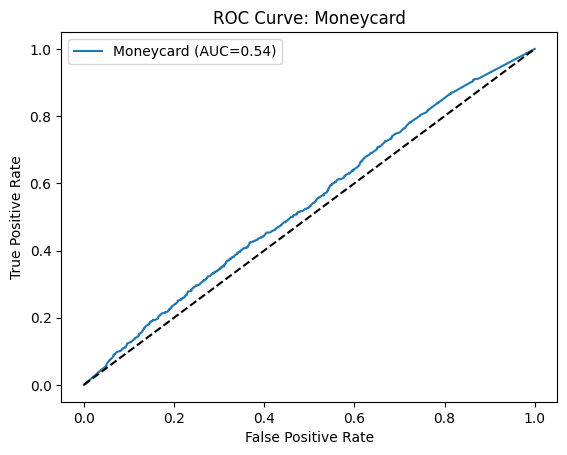

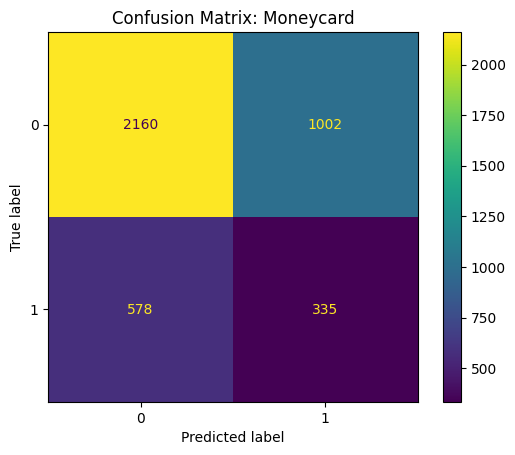

Goldcard AUC: 0.570


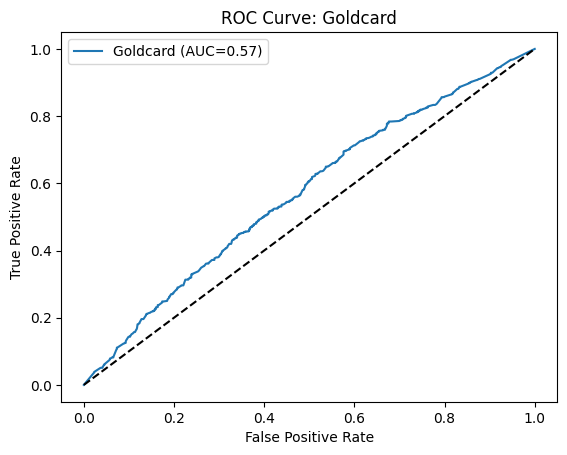

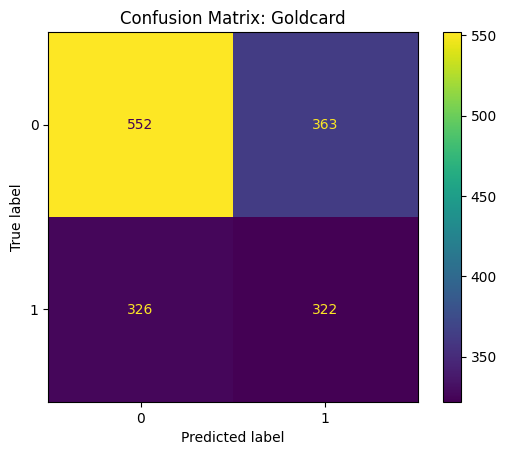

UK_Card AUC: 0.570


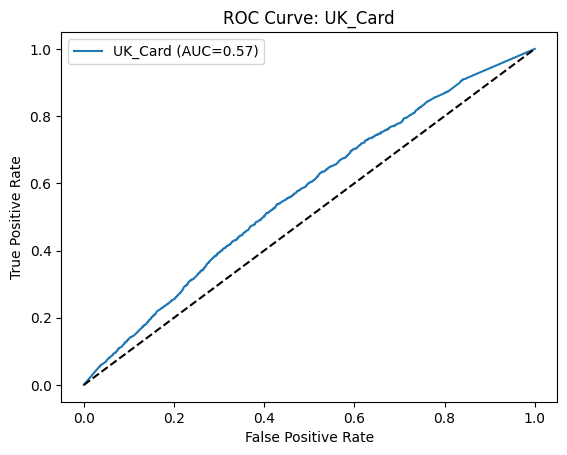

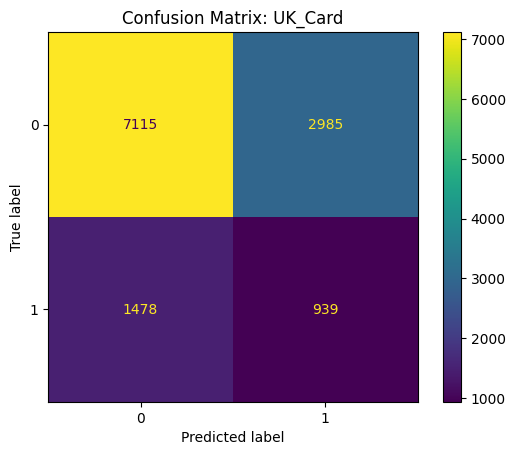

Simplecard AUC: 0.535


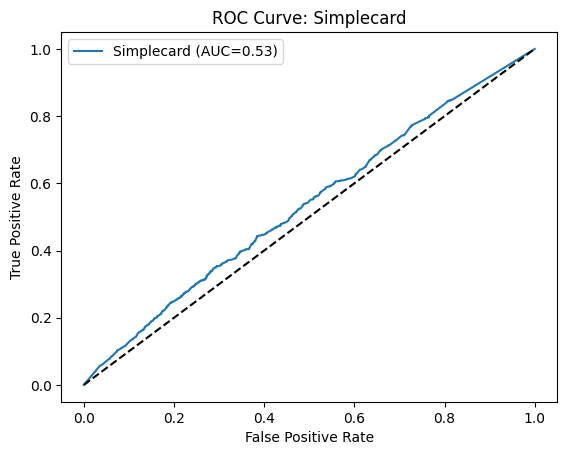

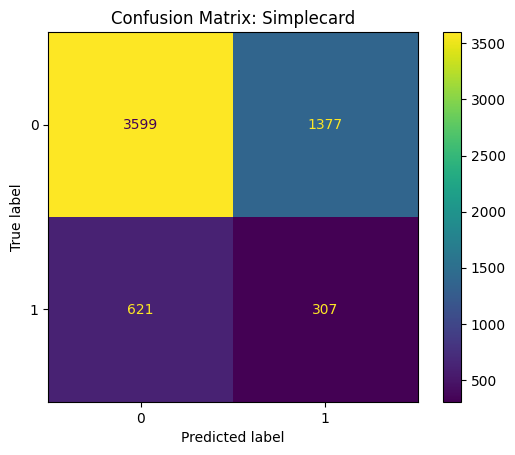

In [134]:
print("\n=== PSP Model Evaluation (Random Forest): AUC/ROC & Confusion Matrices ===")
evaluate_psp_models(psp_models, X_test, y_test, test_data, selected_feature_names)

#### Observation

* AUC in the 0.53–0.57 range suggests modest discriminative power.

In [135]:
# =========== HYPERPARAMETER TUNING (For ALL PSPs) (RandomForest)======================

# Define hyperparameter grid for Random Forest
param_dist = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 5, 10, 20],  # Depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be a leaf node
    'class_weight': [None, 'balanced']  # Balance class weights if needed
}

def tune_all_psps(PSPs, train_data, X_train, y_train, selected_feature_names, param_dist, n_iter=10):
    """
    Performs hyperparameter tuning using RandomizedSearchCV for each PSP's model
    and applies SMOTE to handle class imbalance.

    Parameters:
        PSPs (list): List of Payment Service Providers (PSPs) to train models for.
        train_data (pd.DataFrame): The original training dataset containing the 'PSP' column.
        X_train (pd.DataFrame): Feature matrix for the training set.
        y_train (pd.Series): Target labels for training set.
        selected_feature_names (list): List of feature names to be used for training.
        param_dist (dict): Dictionary of hyperparameters for RandomizedSearchCV.
        n_iter (int): Number of iterations for RandomizedSearchCV.

    Returns:
        dict: Dictionary of best-trained models for each PSP.
    """
    psp_models_tuned = {}

    for psp in PSPs:
        print(f"\n--- Hyperparameter Tuning for PSP: {psp} ---")

        # Step 1: Filter training data for the current PSP
        mask = (train_data['PSP'] == psp)
        X_train_psp = X_train.loc[mask, selected_feature_names]
        y_train_psp = y_train.loc[mask]

        # Skip if no data is available for the current PSP
        if X_train_psp.empty or y_train_psp.empty:
            print(f"Skipping {psp}: No training data available.")
            continue

        # Step 2: Apply SMOTE to balance classes
        smote = SMOTE(random_state=42)
        X_train_psp_res, y_train_psp_res = smote.fit_resample(X_train_psp, y_train_psp)

        # Step 3: Initialize RandomForest and perform hyperparameter tuning
        rf = RandomForestClassifier(random_state=42)
        random_search = RandomizedSearchCV(
            estimator=rf,
            param_distributions=param_dist,
            n_iter=n_iter,
            scoring='f1',  # Optimize for F1 Score (balanced precision-recall)
            cv=3,  # 3-fold cross-validation
            random_state=42,
            verbose=1,  # Display search process
            n_jobs=-1  # Utilize all CPU cores
        )

        # Step 4: Fit the model with hyperparameter tuning
        random_search.fit(X_train_psp_res, y_train_psp_res)

        # Retrieve the best model and its performance
        best_model = random_search.best_estimator_
        best_score = random_search.best_score_
        print(f"Best Parameters for {psp}: {random_search.best_params_}")
        print(f"Best CV F1 Score for {psp}: {best_score:.3f}")

        # Step 5: Store the best model in the dictionary
        psp_models_tuned[psp] = best_model

    return psp_models_tuned

In [136]:
# Define the PSPs to be trained
PSPs = ["Moneycard", "Goldcard", "UK_Card", "Simplecard"]

# Execute the hyperparameter tuning function
psp_models_tuned = tune_all_psps(
    PSPs=PSPs,
    train_data=train_data,
    X_train=X_train,
    y_train=y_train,
    selected_feature_names=selected_feature_names,
    param_dist=param_dist,
    n_iter=10
)


--- Hyperparameter Tuning for PSP: Moneycard ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Moneycard: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'class_weight': 'balanced'}
Best CV F1 Score for Moneycard: 0.666

--- Hyperparameter Tuning for PSP: Goldcard ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Goldcard: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': None}
Best CV F1 Score for Goldcard: 0.589

--- Hyperparameter Tuning for PSP: UK_Card ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for UK_Card: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'class_weight': 'balanced'}
Best CV F1 Score for UK_Card: 0.672

--- Hyperparameter Tuning for PSP: Simplecard ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for 


=== PSP Model Evaluation After Hyperparameter Tuning (RandomForest): AUC/ROC & Confusion Matrices ===

=== PSP Model Evaluation: AUC/ROC & Confusion Matrices ===
Moneycard AUC: 0.554


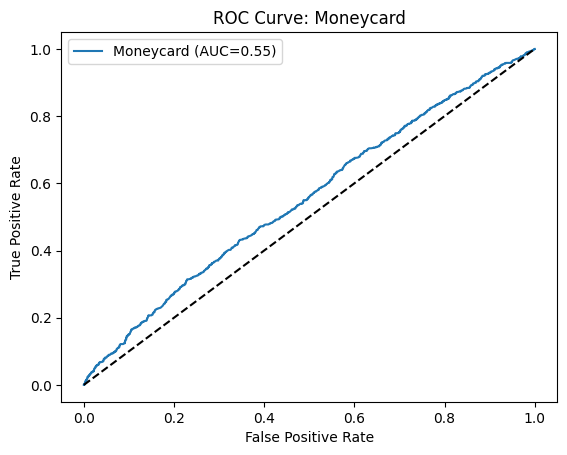

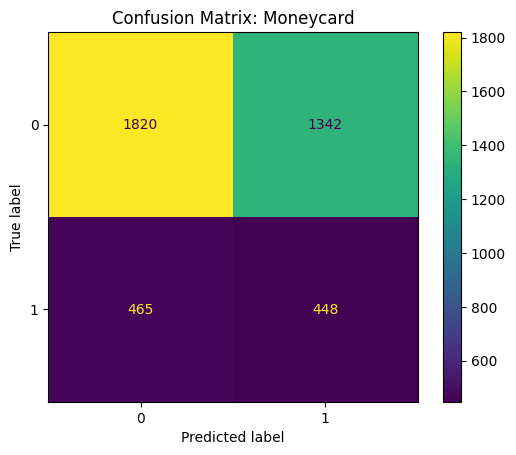

Goldcard AUC: 0.573


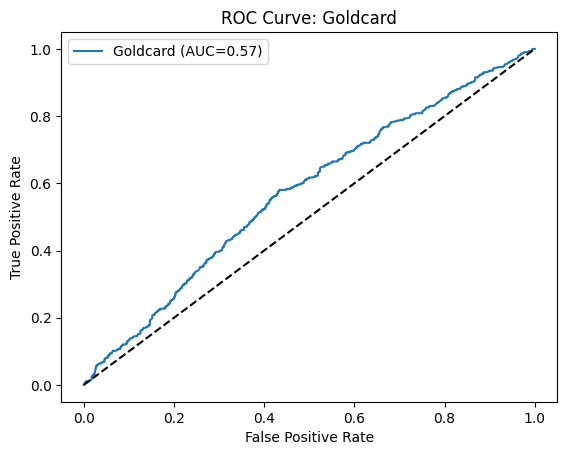

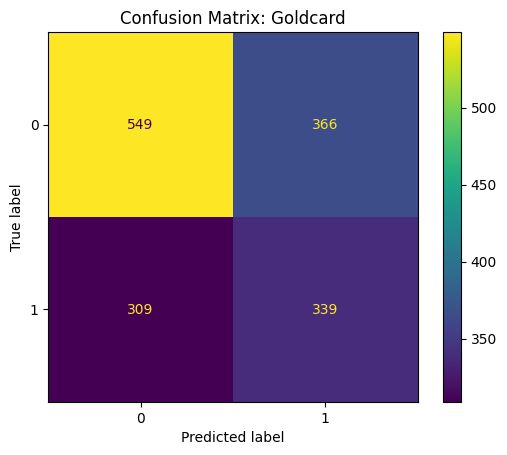

UK_Card AUC: 0.639


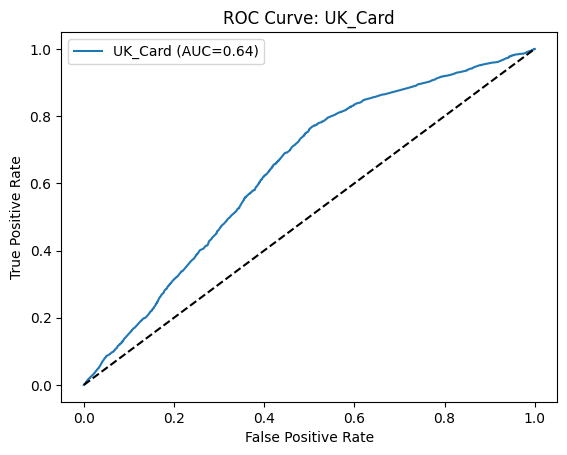

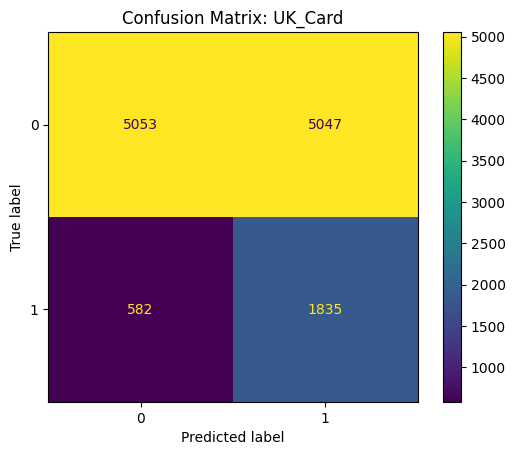

Simplecard AUC: 0.536


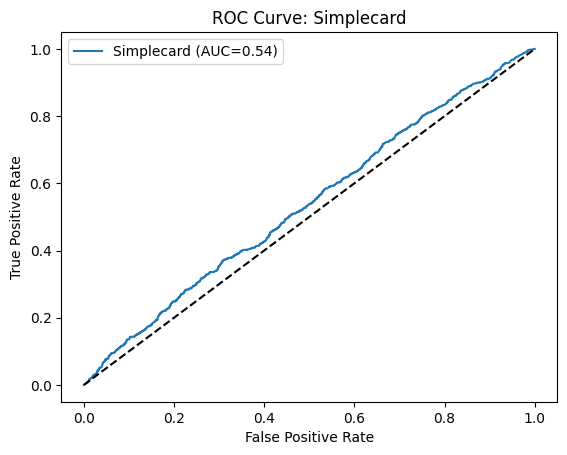

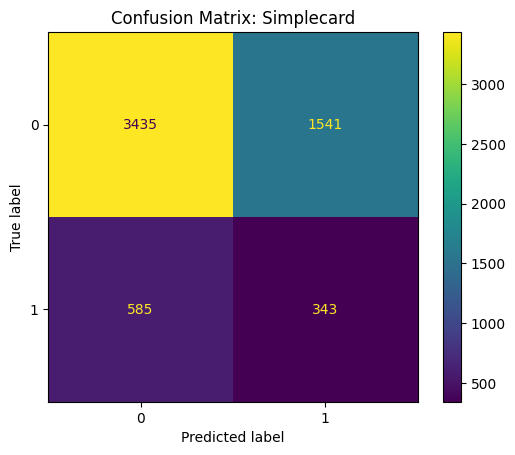

In [137]:
print("\n=== PSP Model Evaluation After Hyperparameter Tuning (RandomForest): AUC/ROC & Confusion Matrices ===")
evaluate_psp_models(psp_models_tuned, X_test, y_test, test_data, selected_feature_names)

In [138]:
# Measure Improvement After Tuning - RandomForest

# Re-run single-attempt cost simulation
def cost_simulation_single_attempt(X_test, y_test, test_data, psp_models, fee_success, fee_fail, selected_feature_names):
    """
    Simulates a single-attempt payment routing scenario where the model selects the best PSP
    based on expected cost and success probability.

    Parameters:
        X_test (pd.DataFrame): Feature matrix for test data.
        y_test (pd.Series): True success labels for the test data.
        test_data (pd.DataFrame): The test dataset containing actual PSP information.
        psp_models (dict): Dictionary of trained PSP models (key = PSP name, value = model).
        fee_success (dict): Transaction fee for successful payments per PSP.
        fee_fail (dict): Transaction fee for failed payments per PSP.
        selected_feature_names (list): List of feature names used for model prediction.

    Returns:
        tuple: (success_rate, avg_cost, cost_per_success)
            - success_rate (float): Proportion of successful transactions.
            - avg_cost (float): Average transaction cost.
            - cost_per_success (float): Cost per successful transaction.
    """
    results = []

    for idx in X_test.index:
        row = X_test.loc[idx, selected_feature_names]

        # Automated PSP Selection - Pick the PSP with the lowest expected cost
        best_psp, best_ecost, best_success_prob = None, float('inf'), 0.0
        for psp, model in psp_models.items():
            prob_success = model.predict_proba([row.values])[0][1]
            ecost = prob_success * fee_success[psp] + (1 - prob_success) * fee_fail[psp]

            if ecost < best_ecost:
                best_ecost = ecost
                best_psp = psp
                best_success_prob = prob_success

        # Simulate success based on selected PSP
        actual_success = y_test.loc[idx]
        historical_psp = test_data.loc[idx, 'PSP']
        success_sim = actual_success if best_psp == historical_psp else int(best_success_prob >= 0.5)

        # Calculate the cost based on success/failure
        sim_cost = fee_success[best_psp] if success_sim == 1 else fee_fail[best_psp]

        results.append({
            'transaction_id': idx,
            'chosen_psp': best_psp,
            'simulated_success': success_sim,
            'simulated_cost': sim_cost
        })

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    success_rate = results_df['simulated_success'].mean()
    avg_cost = results_df['simulated_cost'].mean()

    total_success = results_df['simulated_success'].sum()
    cost_per_success = results_df['simulated_cost'].sum() / total_success if total_success > 0 else np.nan

    return success_rate, avg_cost, cost_per_success

In [139]:
# Model Comparison - Single Attempt

# Evaluate old vs. new single-attempt simulation
old_success_rate, old_avg_cost, old_cps = success_rate_single, avg_cost_single, cost_per_success_single

# Evaluate new tuned model
new_success_rate, new_avg_cost, new_cps = cost_simulation_single_attempt(
    X_test, y_test, test_data, psp_models_tuned, fee_success, fee_fail, selected_feature_names
)

# Print comparison results
print("\n--- Single-Attempt Routing: Model Comparison ---")
print(f"Old Model -> Success: {old_success_rate:.2%}, Cost: {old_avg_cost:.2f}, Cost/Success: {old_cps:.2f}")
print(f"Tuned Model -> Success: {new_success_rate:.2%}, Cost: {new_avg_cost:.2f}, Cost/Success: {new_cps:.2f}")


--- Single-Attempt Routing: Model Comparison ---
Old Model -> Success: 21.65%, Cost: 0.61, Cost/Success: 2.81
Tuned Model -> Success: 24.08%, Cost: 0.62, Cost/Success: 2.58


#### Observation

* **Success Rate** has increased from **21.65%** to **24.08%**, which is quite a noticeable jump.
* **Average Cost** per transaction is roughly similar (0.61 vs. 0.62).
* **Cost per Success** dropped from 2.81 to 2.58, which means you spend slightly more per transaction, but we get **enough** additional successes that the cost per successful transaction **goes down**.

In [140]:
# Multi-Attempt Cost Simulation
def multi_attempt_simulation(test_data_sorted, X_test_feats, psp_models, fee_success, fee_fail, feature_cols):
    """
    Simulates a multiple-attempts payment routing scenario where the model selects the best PSP
    iteratively until a transaction succeeds or all attempts are exhausted.

    Parameters:
        test_data_sorted (pd.DataFrame): Test data sorted by purchase_id and attempt_number.
        X_test_feats (pd.DataFrame): Feature matrix for test data.
        psp_models (dict): Dictionary of trained PSP models.
        fee_success (dict): Success fee per PSP.
        fee_fail (dict): Failure fee per PSP.
        feature_cols (list): List of feature names used for model prediction.

    Returns:
        tuple: (success_rate, avg_fee, cost_per_success)
            - success_rate (float): Final success rate of transactions.
            - avg_fee (float): Average fee per transaction.
            - cost_per_success (float): Cost per successful transaction.
    """
    sim_results = []

    # Process each purchase attempt separately
    for pid, group_df in test_data_sorted.groupby('purchase_id'):
        total_fee = 0
        success_flag = 0

        for idx, row in group_df.iterrows():
            x = X_test_feats.loc[idx, feature_cols].values.reshape(1, -1)

            # Select the PSP with the lowest expected cost
            best_psp, best_ecost, best_prob = None, float('inf'), 0
            for psp, model in psp_models.items():
                prob = model.predict_proba(x)[0][1]
                ecost = prob * fee_success[psp] + (1 - prob) * fee_fail[psp]

                if ecost < best_ecost:
                    best_ecost = ecost
                    best_psp = psp
                    best_prob = prob

            # Simulate transaction success
            success_sim = 1 if np.random.rand() < best_prob else 0
            cost = fee_success[best_psp] if success_sim == 1 else fee_fail[best_psp]
            total_fee += cost

            if success_sim == 1:
                success_flag = 1
                break  # Stop once success is achieved

        sim_results.append({'purchase_id': pid, 'final_success': success_flag, 'total_fee': total_fee})

    # Convert results to DataFrame
    sim_df = pd.DataFrame(sim_results)

    # Compute performance metrics
    success_rate = sim_df['final_success'].mean()
    avg_fee = sim_df['total_fee'].mean()

    if sim_df['final_success'].sum() > 0:
        cost_per_success = sim_df['total_fee'].sum() / sim_df['final_success'].sum()
    else:
        cost_per_success = np.nan

    return success_rate, avg_fee, cost_per_success

In [141]:
# Re-run multi-attempt simulation using tuned models
test_data_sorted = test_data.sort_values(by=['purchase_id', 'attempt_number'])
feature_data_test = X_test[selected_feature_names]

# Retrieve old multi-attempt metrics
multi_sr_old, multi_fee_old, multi_cps_old = final_success_rate, average_fee, cost_per_success

# Run multi-attempt simulation with tuned models
multi_sr_new, multi_fee_new, multi_cps_new = multi_attempt_simulation(
    test_data_sorted, feature_data_test, psp_models_tuned, fee_success, fee_fail, selected_feature_names
)

# Print comparison results
print("\n--- Multi-Attempt Simulation: Model Comparison ---")
print(f"Old Model -> Success: {multi_sr_old:.2%}, Cost: {multi_fee_old:.2f}, Cost/Success: {multi_cps_old:.2f}")
print(f"Tuned Model -> Success: {multi_sr_new:.2%}, Cost: {multi_fee_new:.2f}, Cost/Success: {multi_cps_new:.2f}")


--- Multi-Attempt Simulation: Model Comparison ---
Old Model -> Success: 97.50%, Cost: 1.75, Cost/Success: 1.79
Tuned Model -> Success: 98.75%, Cost: 1.88, Cost/Success: 1.90


#### Observation

* Final success is **98.75%**, which has improved from **97.5%**.
* The **average fee** per purchase has increased slightly from 1.75 to 1.88.
* **Cost/Success** increased slighly from 1.79 to 1.90.

Hence, both single-attempt and multi-attempt scenarios has improved after hyperparameter tuning. This confirms that your new PSP models better discriminate successes from failures and make more cost-effective choices in simulations.

In [142]:
# --------- Implementing LightGBM ---------

def tune_lightgbm_for_psp(PSPs, train_data, X_train, y_train, selected_feature_names, param_dist_lgb, n_iter=10):
    """
    Tunes LightGBM models separately for each PSP using RandomizedSearchCV and SMOTE.

    Parameters:
        PSPs (list): List of PSPs (Payment Service Providers) for which models are trained.
        train_data (pd.DataFrame): Full training dataset containing PSP information.
        X_train (pd.DataFrame): Feature matrix for training.
        y_train (pd.Series): Target variable (1 = success, 0 = failure).
        selected_feature_names (list): List of features used for training.
        param_dist_lgb (dict): Dictionary containing LightGBM hyperparameter search space.
        n_iter (int): Number of iterations for RandomizedSearchCV.

    Returns:
        dict: A dictionary containing the best LightGBM model for each PSP.
    """
    psp_models_tuned = {}

    print("\n=== Hyperparameter Tuning for LightGBM PSP Models ===")

    for psp in PSPs:
        print(f"\n--- Tuning Model for PSP: {psp} ---")

        # 1) Filter training data for the current PSP
        mask = (train_data['PSP'] == psp)
        X_train_psp = X_train.loc[mask, selected_feature_names]
        y_train_psp = y_train.loc[mask]

        # Skip if there is no training data for this PSP
        if len(y_train_psp) == 0:
            print(f"No training data available for {psp}. Skipping.")
            continue

        # 2) Handle class imbalance using SMOTE
        sm = SMOTE(random_state=42)
        X_train_psp_res, y_train_psp_res = sm.fit_resample(X_train_psp, y_train_psp)

        # 3) Initialize LightGBM classifier
        lgb_clf = lgb.LGBMClassifier(random_state=42)

        # 4) Perform Randomized Search for Hyperparameter Tuning
        random_search = RandomizedSearchCV(
            estimator=lgb_clf,
            param_distributions=param_dist_lgb,
            n_iter=n_iter,
            scoring='f1',
            cv=3,
            random_state=42,
            verbose=1,
            n_jobs=-1
        )

        # 5) Train the model
        random_search.fit(X_train_psp_res, y_train_psp_res)

        # 6) Retrieve and store the best model
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
        best_score = random_search.best_score_

        print(f"Best Parameters for {psp}: {best_params}")
        print(f"Best Cross-Validation F1 Score for {psp}: {best_score:.3f}")

        # 7) Store the best model for this PSP
        psp_models_tuned[psp] = best_model

    print("\n=== LightGBM Tuning Completed for All PSPs ===")

    return psp_models_tuned

In [143]:
# Define LightGBM Hyperparameter Search Space
param_dist_lgb = {
    'n_estimators': [50, 100, 200],
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
}

# Run LightGBM Hyperparameter Tuning for PSP Models
psp_models_tuned_lgbm = tune_lightgbm_for_psp(
    PSPs=PSPs,
    train_data=train_data,
    X_train=X_train,
    y_train=y_train,
    selected_feature_names=selected_feature_names,
    param_dist_lgb=param_dist_lgb,
    n_iter=10
)


=== Hyperparameter Tuning for LightGBM PSP Models ===

--- Tuning Model for PSP: Moneycard ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3317, number of negative: 3317
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 315
[LightGBM] [Info] Number of data points in the train set: 6634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Parameters for Moneycard: {'subsample': 1.0, 'num_leaves': 127, 'n_estimators': 200, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Cross-Validation F1 Score for Moneycard: 0.650

--- Tuning Model for PSP: Goldcard ---
Fitting 3 folds for each of 10 cand


=== PSP Model Evaluation After Hyperparameter Tuning (LightGBM): AUC/ROC & Confusion Matrices ===

=== PSP Model Evaluation: AUC/ROC & Confusion Matrices ===
Moneycard AUC: 0.557


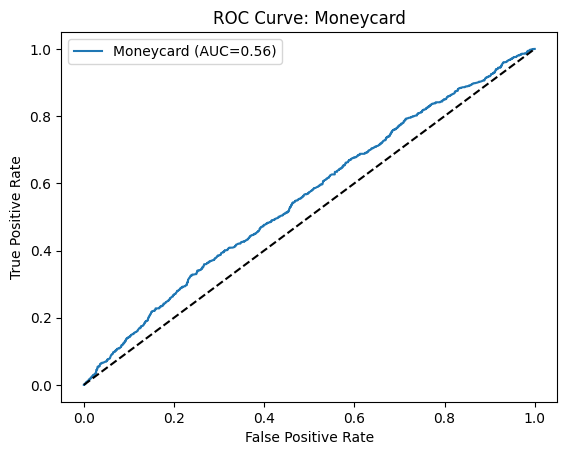

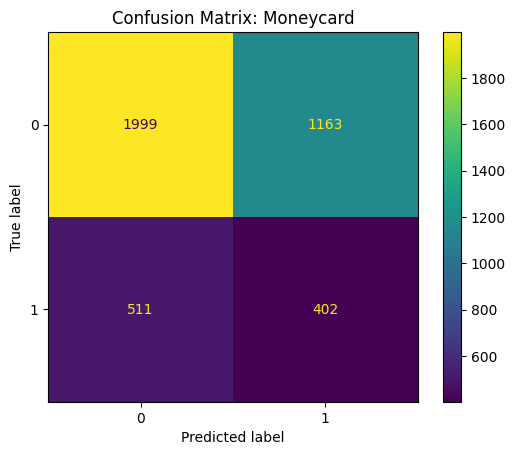

Goldcard AUC: 0.564


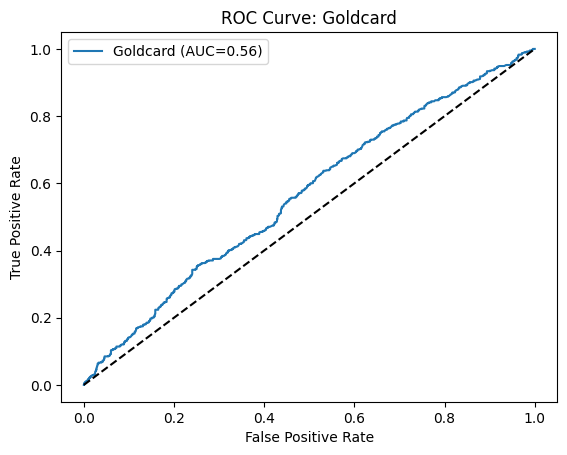

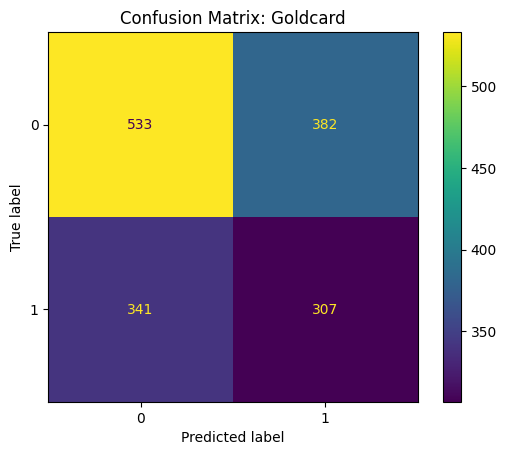

UK_Card AUC: 0.635


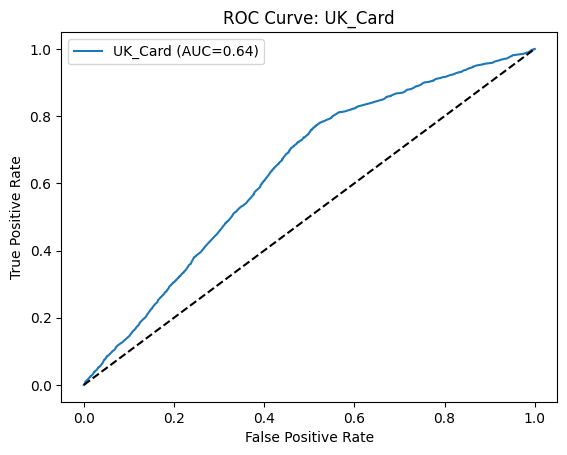

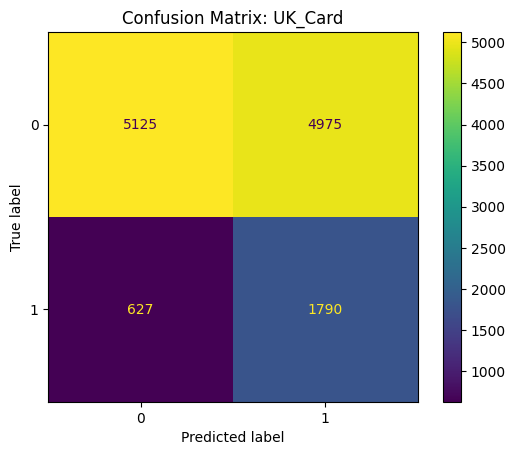

Simplecard AUC: 0.536


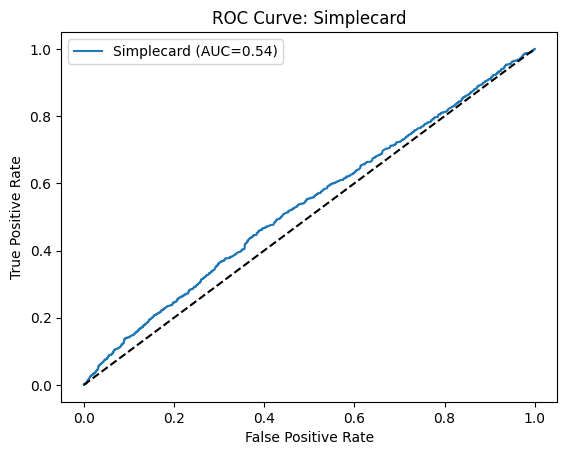

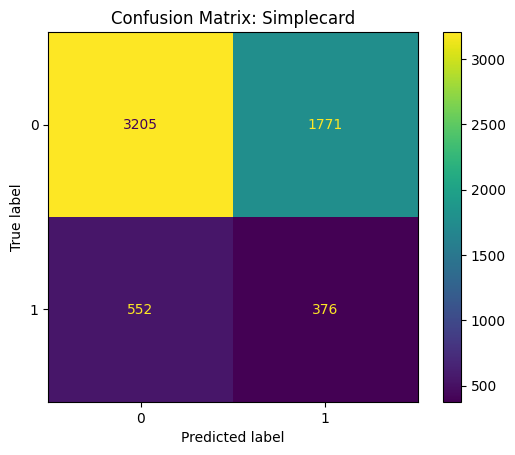

In [144]:
print("\n=== PSP Model Evaluation After Hyperparameter Tuning (LightGBM): AUC/ROC & Confusion Matrices ===")
evaluate_psp_models(psp_models_tuned_lgbm, X_test, y_test, test_data, selected_feature_names)

In [145]:
# Evaluate single-attempt simulation of tuned LightGBM model
new_success_rate_lgbm, new_avg_cost_lgbm, new_cps_lgbm = cost_simulation_single_attempt(
    X_test, y_test, test_data, psp_models_tuned_lgbm, fee_success, fee_fail, selected_feature_names
)

print("\n--- Single-Attempt Routing: LightGBM ---")

print(f"Tuned Model -> Success: {new_success_rate_lgbm:.2%}, Cost: {new_avg_cost_lgbm:.2f}, Cost/Success: {new_cps_lgbm:.2f}")


--- Single-Attempt Routing: LightGBM ---
Tuned Model -> Success: 32.78%, Cost: 0.66, Cost/Success: 2.03


In [147]:
# Evaluate multi-attempt simulation of tuned LightGBM model
multi_sr_new_lgbm, multi_fee_new_lgbm, multi_cps_new_lgbm = multi_attempt_simulation(
    test_data_sorted, feature_data_test, psp_models_tuned_lgbm,
    fee_success, fee_fail, selected_feature_names
)

print("\n--- Multi-Attempt Simulation: Model Comparison ---")
print(f"Tuned Model -> Success: {multi_sr_new_lgbm:.2%}, Cost: {multi_fee_new_lgbm:.2f}, Cost/Success: {multi_cps_new_lgbm:.2f}")


--- Multi-Attempt Simulation: Model Comparison ---
Tuned Model -> Success: 97.50%, Cost: 2.08, Cost/Success: 2.13


* LightGBM yields a much higher single‐attempt success rate (and lower cost/success in that scenario) i.e., **Success: 32.78%, Cost: 0.66, Cost/Success: 2.03**.
* RandomForest is more cost‐efficient in overall when repeated attempts are allowed i.e., **Success: 98.75%, Cost: 1.88, Cost/Success: 1.90**.


So, we will choose **Random Forest** model as it more cost‐efficient overall when repeated attempts are allowed.

# 8. Feature Importance & Interpretability

## 8.1 Feature Importance

In [148]:
# Model-based feature importance
def plot_model_based_importances(psp_models, feature_names, top_n=10):
    """
    Plots bar charts of feature importances for each PSP model.

    This method uses `model.feature_importances_`, which is available for tree-based models
    such as RandomForest and LightGBM.

    Parameters:
        psp_models (dict): Dictionary of PSP models where keys are PSP names and values are trained models.
        feature_names (list): List of feature names.
        top_n (int): Number of top important features to plot.

    Returns:
        None: Displays bar plots of feature importances.
    """
    for psp, model in psp_models.items():
        # Check if the model has `feature_importances_` attribute
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_

            # Sort feature importances in descending order
            indices = np.argsort(importances)[::-1]
            top_indices = indices[:top_n]

            # Plot the top N feature importances
            plt.figure(figsize=(8, 5))
            plt.title(f"{psp} - Top {top_n} Feature Importances (Model-Based)")
            plt.barh(
                [feature_names[i] for i in top_indices][::-1],  # Reverse for better readability
                importances[top_indices][::-1],
                color="steelblue"
            )
            plt.xlabel("Importance Score")
            plt.ylabel("Feature")
            plt.tight_layout()
            plt.show()
        else:
            print(f"Model for PSP={psp} has no `feature_importances_`; skipping.")

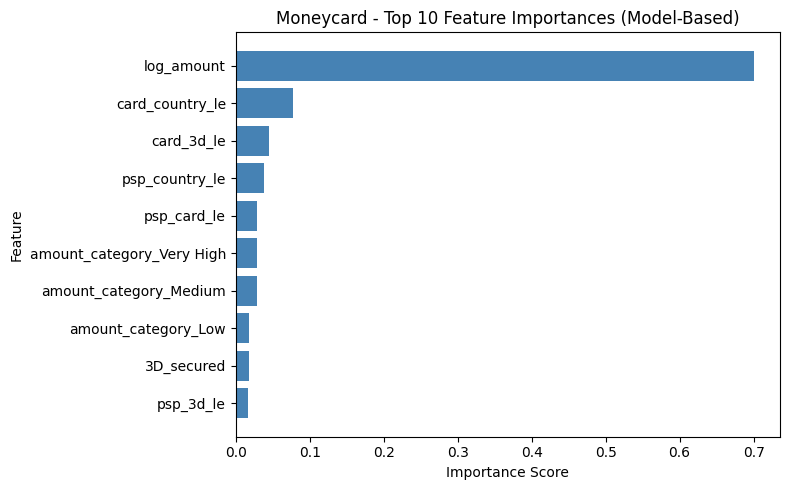

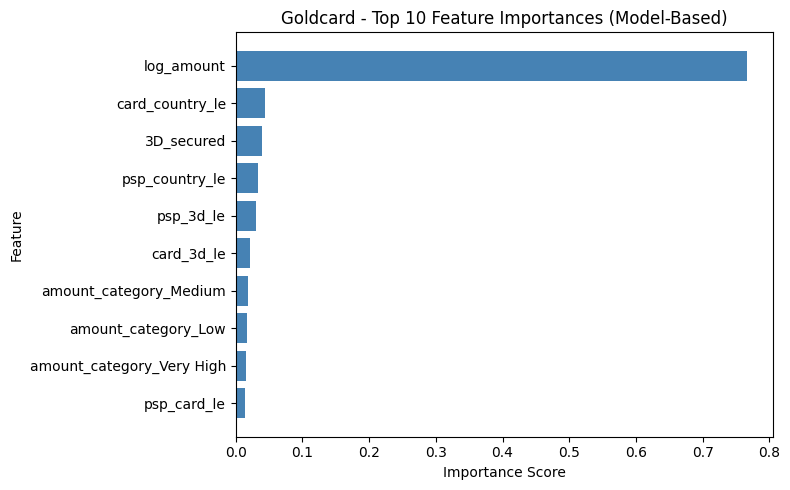

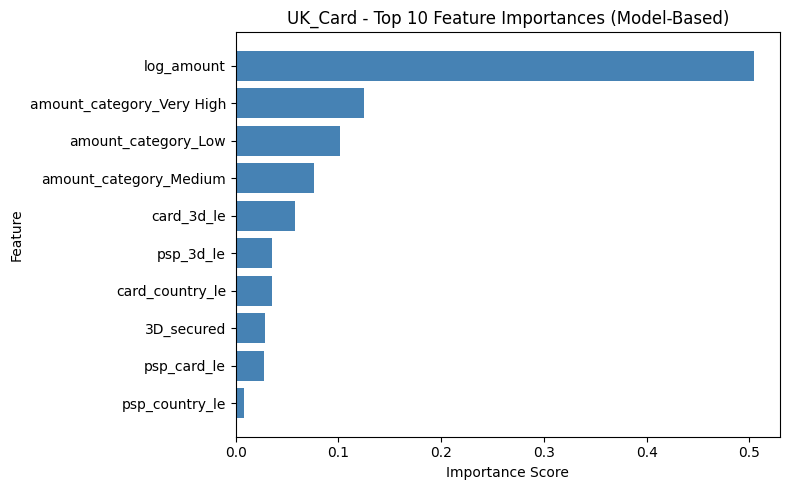

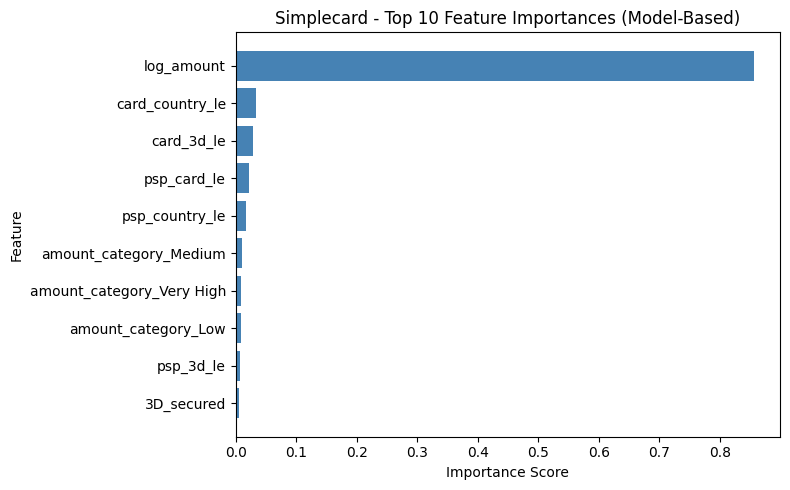

In [149]:
# Plot model-based importances (Random Forest)
plot_model_based_importances(
    psp_models=psp_models_tuned,
    feature_names=selected_feature_names,
    top_n=10
)

#### Observation

1. **Dominance** of `log_amount`:

* In all four PSP models (Moneycard, Goldcard, UK_Card, Simplecard), the feature log_amount has the highest importance score by a significant margin.
* This indicates that transaction amount (log-transformed) is the most critical factor in determining model predictions.

2. `card_country_le` **is consistently important**:

* `card_country_le` appears as one of the top influential features across all models.
* This suggests that the country where the card is issued plays a crucial role in prediction.

3. **Importance of** `card_3d_le` and `psp_3d_le`:

* Features related to 3D security (card_3d_le, psp_3d_le, and 3D_secured) appear in all models.
* This highlights the significance of 3D authentication mechanisms in decision-making.

4. **Variability in Amount Category Features** (`amount_category_Very High`, `amount_category_Medium`, `amount_category_Low`):

* The UK_Card model gives relatively higher importance to transaction amount categories compared to others.
* In contrast, other models tend to prioritize card_country_le and psp_country_le more.

5. **Consistency across PSPs**:

* The overall feature importance rankings are similar across different PSPs.
* This indicates that the underlying model behavior and key predictive features are relatively stable across datasets.

## 8.2 Permutation Importance

In [150]:
def plot_permutation_importances(psp_models, X, y, feature_names, top_n=10):
    """
    Plots permutation importances for each PSP model on a given dataset (X, y).

    Permutation importance is computed by randomly shuffling feature values and measuring
    the decrease in model performance (F1 score). This method is computationally expensive
    but provides reliable importance estimates.

    Parameters:
        psp_models (dict): Dictionary of PSP models where keys are PSP names and values are trained models.
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target labels.
        feature_names (list): List of feature names.
        top_n (int): Number of top important features to plot.

    Returns:
        None: Displays bar plots of permutation importances.
    """
    for psp, model in psp_models.items():
        print(f"\n=== Permutation Importance for PSP: {psp} ===")

        # Compute permutation importance
        result = permutation_importance(model, X, y, n_repeats=5, random_state=42, scoring="f1")
        sorted_idx = result.importances_mean.argsort()[::-1]

        # Select top N most important features
        top_indices = sorted_idx[:top_n]

        # Plot feature importances
        plt.figure(figsize=(8, 5))
        plt.title(f"{psp} - Top {top_n} Permutation Importances")
        plt.barh(
            [feature_names[i] for i in top_indices][::-1],  # Reverse for better readability
            result.importances_mean[top_indices][::-1],
            xerr=result.importances_std[top_indices][::-1],  # Error bars for standard deviation
            color="forestgreen",
            align="center"
        )
        plt.xlabel("Mean Importance (F1 Score Decrease)")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()


=== Permutation Importance for PSP: Moneycard ===


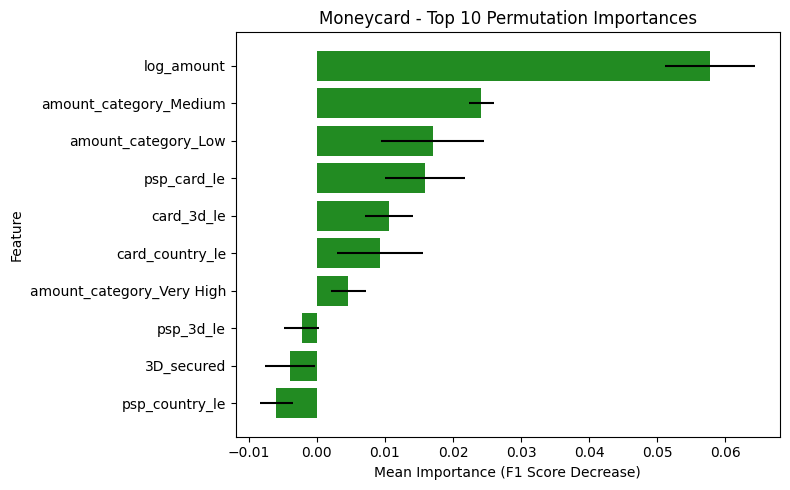


=== Permutation Importance for PSP: Goldcard ===


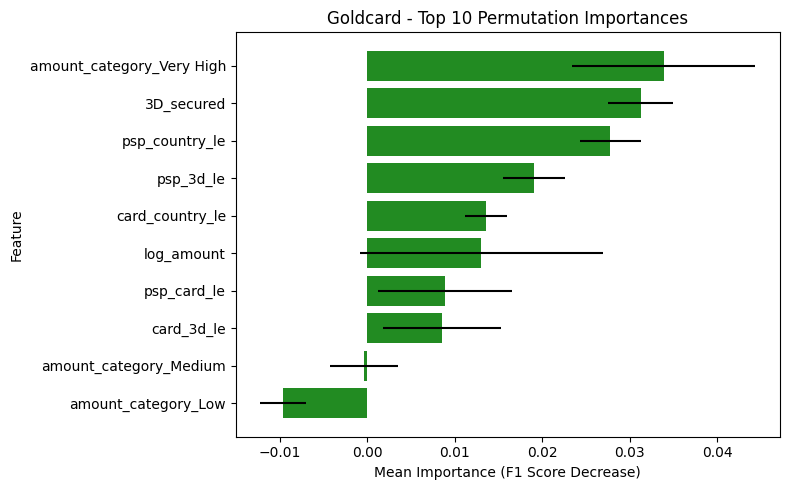


=== Permutation Importance for PSP: UK_Card ===


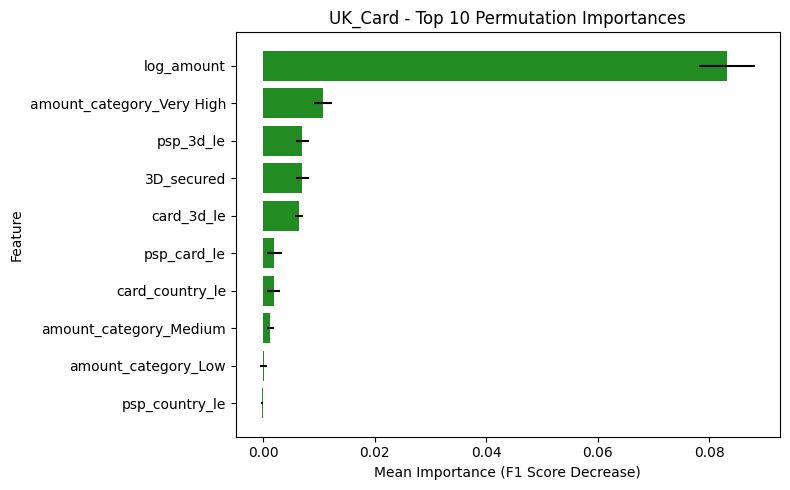


=== Permutation Importance for PSP: Simplecard ===


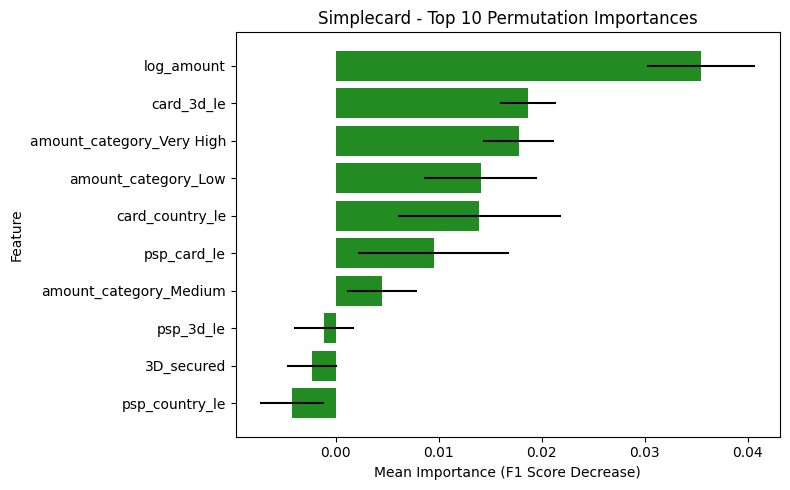

In [151]:
# Compute and plot permutation importance for each PSP's test data subset
for psp in PSPs:
    # Select only the transactions processed by this PSP
    mask = (test_data['PSP'] == psp)
    X_test_psp = X_test.loc[mask, selected_feature_names]
    y_test_psp = y_test.loc[mask]

    # Ensure there is test data for the PSP before running importance analysis
    if len(y_test_psp) > 0:
        plot_permutation_importances(
            psp_models={psp: psp_models_tuned[psp]},  # Evaluate the specific PSP's model
            X=X_test_psp,
            y=y_test_psp,
            feature_names=selected_feature_names,
            top_n=10
        )
    else:
        print(f"Skipping PSP {psp}: No test samples available.")

#### Observation

1. `log_amount` Remains the Most Critical Feature.

2. `card_country_le` and `psp_country_le` are Significant.

3. `3D_secured` and `card_3d_le` Remain Relevant but Less Dominant.

# 9. Sophisticated Error Analysis

In [152]:
# Convert arrays back to DataFrames with same index & columns for consistent indexing in subsequent steps
X_train_selected_df = pd.DataFrame(
    X_train_selected, 
    index=X_train_res.index,
    columns=selected_feature_names
)

X_test_selected_df = pd.DataFrame(
    X_test_selected,
    index=X_test.index,
    columns=selected_feature_names
)

print("X_test_selected_df shape:", X_test_selected_df.shape)
print("Selected feature names:", selected_feature_names.tolist())

X_test_selected_df shape: (24059, 10)
Selected feature names: ['log_amount', '3D_secured', 'psp_card_le', 'psp_3d_le', 'card_3d_le', 'psp_country_le', 'card_country_le', 'amount_category_Low', 'amount_category_Medium', 'amount_category_Very High']


In [153]:
def segmented_error_analysis(psp_models, 
                            X_test_selected_df, 
                            y_test, 
                            test_data, 
                            selected_feature_names, 
                            segment_col='country'):
    """
    Produces classification metrics for each PSP within each segment in `segment_col`.
    
    Parameters
    ----------
    psp_models : dict
        Dict of PSP-specific trained models, e.g. {'Moneycard': model, 'Goldcard': model, ...}.
    X_test_selected_df : pd.DataFrame
        DataFrame of shape (n_samples, k_features) with the same columns used during training
        (i.e., `selected_feature_names`). Indexed identically to `y_test` and `test_data`.
    y_test : pd.Series
        True success/fail labels (0/1) for the test set, same index as X_test_selected_df.
    test_data : pd.DataFrame
        Original test data that includes columns like 'PSP', 'country', 'card', etc. for grouping.
        Must have the same index alignment as X_test_selected_df and y_test.
    selected_feature_names : list
        The list of columns in `X_test_selected_df`.
    segment_col : str
        The column in `test_data` to group by (e.g., 'country', 'card').

    Returns
    -------
    None
        Prints classification reports for each PSP within each segment.
    """
    # Unique segments (e.g., unique countries)
    segments = test_data[segment_col].unique()
    
    for segment in segments:
        # For the chosen segment, build a boolean mask
        seg_mask = (test_data[segment_col] == segment)

        # Subset X and y by that mask
        X_seg = X_test_selected_df.loc[seg_mask, selected_feature_names]
        y_seg = y_test.loc[seg_mask]

        # The historically used PSP in those rows
        psp_seg = test_data.loc[seg_mask, 'PSP']

        print(f"\n=== Segment: {segment_col} = {segment} ===")
        
        # Evaluate each PSP that occurs in this segment
        for psp in psp_seg.unique():
            model = psp_models.get(psp, None)
            if model is None:
                # No trained model for this PSP, skip
                continue

            # Mask for only those rows that used this PSP
            psp_mask = (psp_seg == psp)
            X_psp_seg = X_seg.loc[psp_mask]
            y_psp_seg = y_seg.loc[psp_mask]

            if len(X_psp_seg) == 0:
                continue

            # Generate predictions using the PSP-specific model
            y_pred = model.predict(X_psp_seg)

            print(f"\n--- PSP = {psp}, {segment_col} = {segment} ---")
            print(classification_report(y_psp_seg, y_pred, digits=3))

In [155]:
# for country-based segmentation:
segmented_error_analysis(
    psp_models=psp_models_tuned,
    X_test_selected_df=X_test_selected_df,  # pass the DataFrame version
    y_test=y_test,
    test_data=test_data,
    selected_feature_names=selected_feature_names,
    segment_col='country'
)


=== Segment: country = Austria ===

--- PSP = UK_Card, country = Austria ---
              precision    recall  f1-score   support

           0      0.891     0.502     0.642      1954
           1      0.276     0.755     0.404       490

    accuracy                          0.553      2444
   macro avg      0.583     0.629     0.523      2444
weighted avg      0.768     0.553     0.594      2444


--- PSP = Moneycard, country = Austria ---
              precision    recall  f1-score   support

           0      0.813     0.517     0.632       630
           1      0.249     0.574     0.348       176

    accuracy                          0.530       806
   macro avg      0.531     0.546     0.490       806
weighted avg      0.690     0.530     0.570       806


--- PSP = Simplecard, country = Austria ---
              precision    recall  f1-score   support

           0      0.852     0.651     0.738       962
           1      0.164     0.377     0.229       175

    accuracy   

#### Observations

1. **Overall Performance Trends by Country**:
* Germany has the lowest overall accuracy (~55-65%) across all PSPs.
* Switzerland has slightly better F1-scores but still struggles (~55-62%).
* Austria has similar patterns to Switzerland, with accuracy around (~55-62%).
* UK_Card and Simplecard perform poorly across all segments, with high false positives.
* Goldcard is more balanced but does not dominate any particular category.


2. **Breakdown by Country & PSP Performance**:

* Goldcard has the best balance between recall & precision in Austria.
* UK_Card has the worst performance, especially in identifying failures.
* Simplecard fails to predict successful transactions correctly.
* Simplecard performs best in Switzerland, but still has high false negatives.
* Goldcard remains the most balanced option.
* UK_Card performs poorly in Switzerland.
* Germany has the worst PSP success rates across all providers.
* Goldcard has the best recall but remains unreliable.
* UK_Card and Simplecard struggle significantly.
* Moneycard performs poorly overall.


3. **Key Business Insights**:
    1. **Austria has the best overall performance among the three countries.**
    * Goldcard is the best option with a recall of ~66%.
    * Simplecard struggles with predicting success.
    * UK_Card should not be used for Austria.

    2. **Switzerland has slightly better PSP performance than Germany but still struggles.**
    * Simplecard has the best accuracy (~62%) but high false negatives.
    * Goldcard remains a strong alternative but has room for improvement.
    * UK_Card is unreliable.

    3. **Germany has the lowest PSP success rates.**
    * All PSPs struggle in Germany, with accuracy around ~55-65%.
    * Goldcard is again the most balanced PSP.
    * Simplecard and UK_Card are unreliable.

    4. **Goldcard is the most consistent PSP overall**
    * It never ranks as the worst in any country.
    * For all card types, it provides a good balance of precision & recall.

In [157]:
# for card-based segmentation:
segmented_error_analysis(
    psp_models=psp_models_tuned,
    X_test_selected_df=X_test_selected_df,
    y_test=y_test,
    test_data=test_data,
    selected_feature_names=selected_feature_names,
    segment_col='card'
)


=== Segment: card = Master ===

--- PSP = UK_Card, card = Master ---
              precision    recall  f1-score   support

           0      0.912     0.463     0.614      5765
           1      0.265     0.812     0.400      1374

    accuracy                          0.530      7139
   macro avg      0.588     0.638     0.507      7139
weighted avg      0.787     0.530     0.573      7139


--- PSP = Simplecard, card = Master ---
              precision    recall  f1-score   support

           0      0.891     0.787     0.836      3056
           1      0.130     0.247     0.170       392

    accuracy                          0.726      3448
   macro avg      0.510     0.517     0.503      3448
weighted avg      0.804     0.726     0.760      3448


--- PSP = Moneycard, card = Master ---
              precision    recall  f1-score   support

           0      0.790     0.470     0.590      1829
           1      0.238     0.570     0.335       530

    accuracy                   

#### Observations

1. **Overall Performance Trends**:
* MasterCard transactions have the lowest overall accuracy (~50-55%) across all PSPs.
* Diners transactions have slightly better F1-scores but still struggle (~50-55%).
* Visa transactions generally perform better, especially for Moneycard (~76% accuracy).
* UK_Card and Simplecard perform poorly across most segments, with high false positives.
* Goldcard is more balanced but does not dominate any particular category.


2. **Breakdown by Card Type & PSP Performance**:

* MasterCard transactions have a high failure rate, regardless of PSP.
* Goldcard is the best option here, but none of the PSPs perform well overall.
* Diners transactions perform slightly better than MasterCard but still weak.
* UK_Card has the highest recall (~73%) but is inaccurate.
* Goldcard is again the most balanced PSP but still struggles.
* Visa transactions perform best across all PSPs.
* Moneycard has the best accuracy (~76%) but poor recall.
* Goldcard is again the most balanced PSP but is not the most accurate.


3. **Key Business Insights**:
    1. **MasterCard transactions are the most problematic**
    * Low recall rates across all PSPs, meaning actual successful payments are often missed.
    * Goldcard is the most balanced PSP, but none are truly reliable.

    2. **Diners transactions are slightly better, but still unstable**
    * UK_Card has high recall (~73%) but is highly inaccurate overall.
    * Goldcard remains the most balanced option but still struggles.

    3. **Visa transactions have the best PSP performance**
    * Moneycard has the best accuracy (~76%) but low recall.
    * Goldcard is the best balanced PSP across all segments.

    4. **Goldcard is the most consistent PSP overall**
    * It never ranks as the worst in any segment.
    * For all card types, it provides a good balance of precision & recall.

In [164]:
psp_models_tuned.items()

dict_items([('Moneycard', RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)), ('Goldcard', RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42)), ('UK_Card', RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, random_state=42)), ('Simplecard', RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50, random_state=42))])

In [158]:
# Build a single dictionary that contains all details
routing_data = {
    "models": psp_models_tuned,             # Key: "models" storing your PSP models
    "label_encoders": my_label_encoders,    # Key: "label_encoders" for all label encoding
    "bin_edges": bin_edges_,                # Key: "bin_edges" from qcut
    "bin_labels": bin_labels_,              # Key: "bin_labels" from qcut
    "fee_success": fee_success,             # Key: "fee_success" dictionary
    "fee_fail": fee_fail,                   # Key: "fee_fail" dictionary
    "selected_features": list(selected_feature_names)  # Key: "selected_features"
}

In [171]:
# Define model directory and path
model_dir = Path("../models")
model_path = model_dir / "credit_card_routing_rf_psp_models.joblib"
routing_data_path = model_dir / "routing_data_psp_models.joblib"

# Create directory if it doesn't exist
model_dir.mkdir(parents=True, exist_ok=True)

# Save the model
joblib.dump(psp_models_tuned, model_path)
print("The model has been saved successfully to the path:", model_path)

# save the routing data
joblib.dump(routing_data, routing_data_path)
print("The routing data has been saved successfully to the path:", routing_data_path)

The model has been saved successfully to the path: ../models/credit_card_routing_rf_psp_models.joblib
The routing data has been saved successfully to the path: ../models/routing_data_psp_models.joblib
